<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1613476412.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])


Total rows: 13821

First 5 rows:
      head      relation        tail
0  olivia0      sisterOf    selina10
1  olivia0      sisterOf  isabella11
2  olivia0      sisterOf     oskar24
3  olivia0      sisterOf       adam9
4  olivia0  secondAuntOf      lena18

Relationship Counts:
relation
grandsonOf                      814
grandmotherOf                   813
grandfatherOf                   813
granddaughterOf                 812
motherOf                        733
fatherOf                        733
sisterOf                        636
daughterOf                      628
greatGrandsonOf                 624
greatGrandmotherOf              617
greatGrandfatherOf              617
greatGranddaughterOf            610
sonOf                           600
brotherOf                       570
auntOf                          556
nephewOf                        514
nieceOf                         496
uncleOf                         454
girlCousinOf                    445
boyCousinOf                   

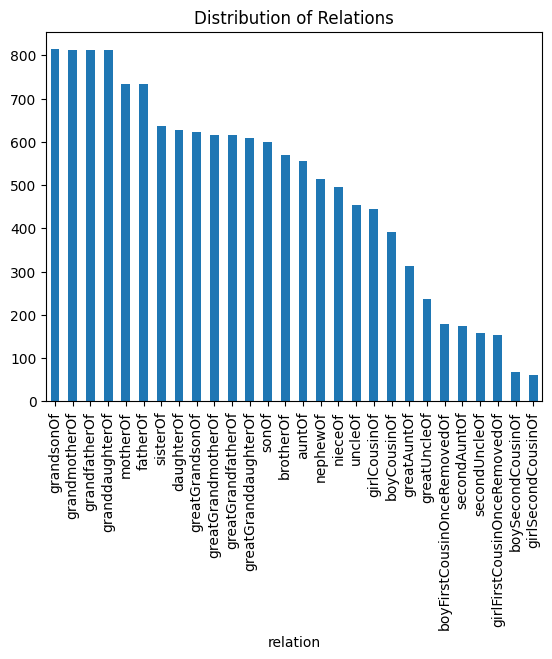

In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load the dataset
file_path = '/kaggle/input/train-txt/train.txt'

# The file has no header, so we name the columns manually
df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])

# 2. Basic Sanity Check
print(f"Total rows: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())

# 3. Task Requirement: "What's the distribution of different relationships?" 
print("\nRelationship Counts:")
print(df['relation'].value_counts())

# Optional: Plot the distribution
df['relation'].value_counts().plot(kind='bar', title='Distribution of Relations')
plt.show()

In [54]:
# Create a Directed Graph
G = nx.MultiDiGraph()

# Add edges from the dataframe
# zip() lets us iterate through the 3 columns simultaneously
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# Task Requirement: "How many people are there?" [cite: 68]
print(f"Number of Nodes (People): {G.number_of_nodes()}")
print(f"Number of Edges (Relationships): {G.number_of_edges()}")

# Check if the graph is connected (Can you reach everyone from everyone?)
# Since it's directed, we check "weakly connected" (ignoring direction) to see if it's one big family or islands.
print(f"Is the graph connected? {nx.is_weakly_connected(G)}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

Number of Nodes (People): 1316
Number of Edges (Relationships): 13821
Is the graph connected? False
Number of connected components: 50



Component Size Distribution:
  Largest family: 27 people
  Smallest family: 26 people
  Median family size: 26 people
  Top 10 family sizes: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


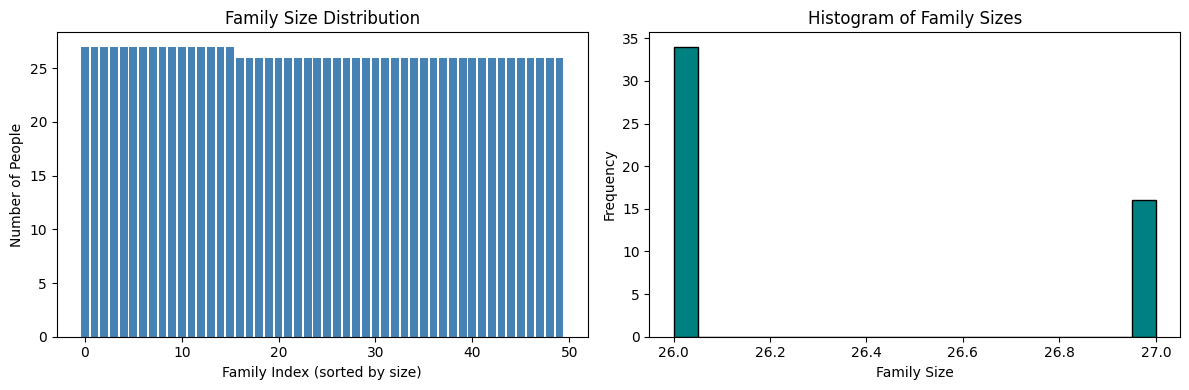

In [55]:
# --- Component Size Distribution ---
component_sizes = sorted([len(c) for c in nx.weakly_connected_components(G)], reverse=True)

print(f"\nComponent Size Distribution:")
print(f"  Largest family: {component_sizes[0]} people")
print(f"  Smallest family: {component_sizes[-1]} people")
print(f"  Median family size: {component_sizes[len(component_sizes)//2]} people")
print(f"  Top 10 family sizes: {component_sizes[:10]}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(component_sizes)), component_sizes, color='steelblue')
plt.xlabel("Family Index (sorted by size)")
plt.ylabel("Number of People")
plt.title("Family Size Distribution")

plt.subplot(1, 2, 2)
plt.hist(component_sizes, bins=20, color='teal', edgecolor='black')
plt.xlabel("Family Size")
plt.ylabel("Frequency")
plt.title("Histogram of Family Sizes")
plt.tight_layout()
plt.show()

In [56]:
# 1. Degree Centrality (Who has the most direct connections?)
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

print("Top 5 Most Connected People (Hubs):")
for node, degree in sorted_degree[:5]:
    print(f"{node}: {degree} connections")

# 2. Graph Density (How 'tight' is the family?)
density = nx.density(G)
print(f"\nGraph Density: {density:.6f}")
# Insight: Family trees are usually sparse (low density).

# 3. Diameter (Longest shortest path)
# Note: Diameter creates errors if the graph is disconnected.
# We calculate it on the largest component only.
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc_nodes)

# Warning: This might be slow on 13k nodes. If it hangs, skip it.
try:
    # We treat it as undirected for 'family distance'
    diameter = nx.diameter(largest_subgraph.to_undirected())
    print(f"Diameter of the largest family cluster: {diameter}")
except Exception as e:
    print("Could not calculate diameter (graph might be too complex/disconnected)")

Top 5 Most Connected People (Hubs):
dominik1036: 45 connections
magdalena1044: 45 connections
oliver1045: 45 connections
lisa1035: 45 connections
oskar133: 44 connections

Graph Density: 0.007987
Diameter of the largest family cluster: 3


Visualizing the neighborhood of: dominik1036


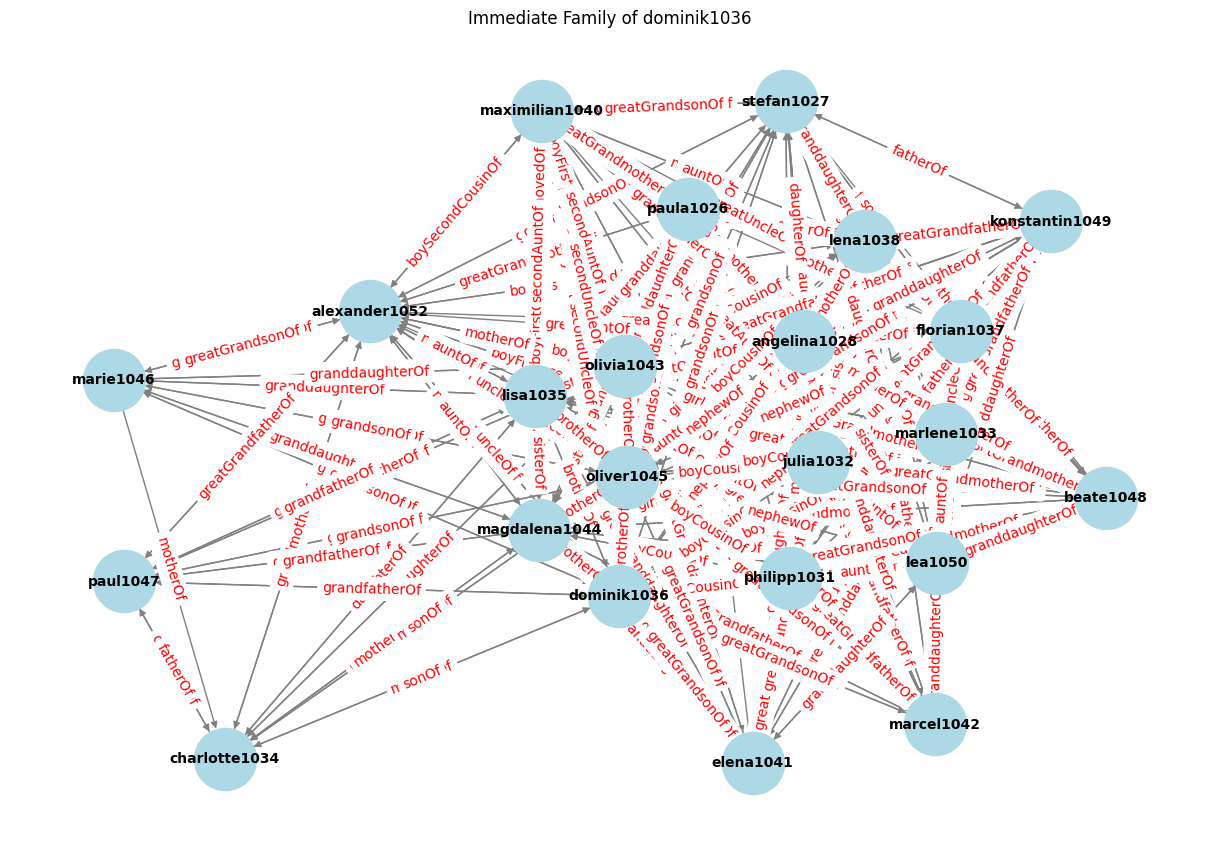

In [57]:
# Pick the most connected person from Step 3 (e.g., 'olivia0' or whoever was #1)
center_node = sorted_degree[0][0] 
print(f"Visualizing the neighborhood of: {center_node}")

# Create a subgraph of just this person and their direct neighbors (Radius=1)
# Radius=2 will show neighbors of neighbors (grandparents/cousins)
subgraph = nx.ego_graph(G, center_node, radius=1)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # consistent layout

# Draw nodes and edges
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels (relationships)
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.title(f"Immediate Family of {center_node}")
plt.show()

Found 495 ancestral roots (founding members).

Population by Generation:
0    495
1    215
2    192
3    206
4    146
5     55
6      7
Name: count, dtype: int64


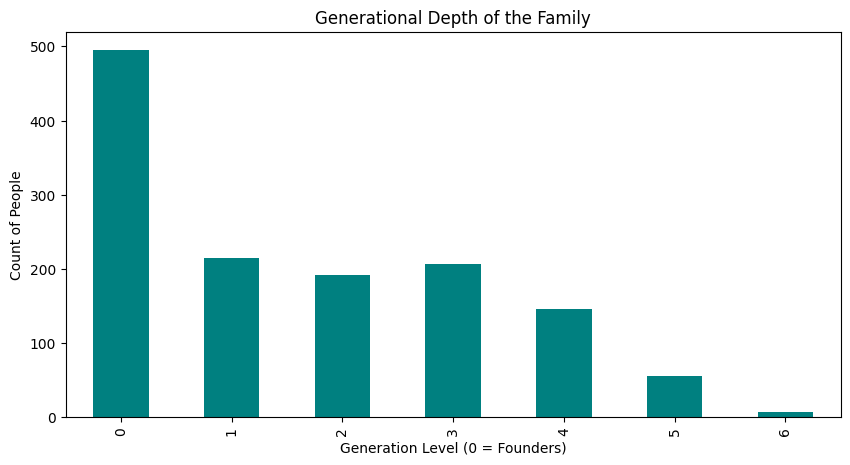

In [58]:
# --- ADVANCED ANALYSIS 1: Generation Detection ---
# Goal: Assign a 'Generation Level' to nodes based on parent/child links.

# 1. Filter for "Vertical" edges only
# We ignore "sisterOf" or "cousinOf" because they stay within the same generation.
# We only care about edges that move TIME forward or backward.
# Let's standardize: Parent -> Child edges.
vertical_relations = ['fatherOf', 'motherOf']
inverse_vertical = ['sonOf', 'daughterOf']

# Create a "Time Graph" (Parents pointing to Children)
time_graph = nx.DiGraph()
for u, v, data in G.edges(data=True):
    r = data['relation']
    if r in vertical_relations:
        time_graph.add_edge(u, v)  # Parent -> Child
    elif r in inverse_vertical:
        time_graph.add_edge(v, u)  # Child -> Parent (flip to Parent -> Child)

# 2. Find the "Ancestors" (Roots)
# These are people with 0 incoming edges in our Time Graph (No parents listed)
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]
print(f"Found {len(ancestors)} ancestral roots (founding members).")

# 3. Calculate Generations (Longest Path from an Ancestor)
# We use a topological sort approach or simple BFS/DFS layer count.
generations = {}
# Initialize ancestors as Generation 0
for root in ancestors:
    generations[root] = 0

# Propagate down
# Note: This is a simplification. A robust way is 'longest path' in a DAG.
for node in nx.topological_sort(time_graph):
    if node not in generations:
        parents = list(time_graph.predecessors(node))
        if parents:
            # You are 1 generation below your 'youngest' parent recorded
            parent_gens = [generations.get(p, 0) for p in parents]
            generations[node] = max(parent_gens) + 1
        else:
            generations[node] = 0

# 4. Visualization: The "Demographic Pyramid"
gen_counts = pd.Series(generations.values()).value_counts().sort_index()
print("\nPopulation by Generation:")
print(gen_counts)

plt.figure(figsize=(10, 5))
gen_counts.plot(kind='bar', color='teal')
plt.title("Generational Depth of the Family")
plt.xlabel("Generation Level (0 = Founders)")
plt.ylabel("Count of People")
plt.show()

In [59]:
# --- INVESTIGATE: Why 495 ancestral roots? ---
# Let's understand who these "ancestors" are

print(f"Total nodes in time_graph: {time_graph.number_of_nodes()}")
print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Nodes NOT in time_graph: {G.number_of_nodes() - time_graph.number_of_nodes()}")

# Nodes with no parents in the data
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]

# What relationships DO these ancestors have?
ancestor_relations = df[df['head'].isin(ancestors)]['relation'].value_counts()
print(f"\nRelationships held by 'ancestors' (nodes with no parents recorded):")
print(ancestor_relations.head(15))

# Check: Are some "ancestors" actually middle-generation people with missing parent data?
# If someone is an "ancestor" but has grandchildren, their parents are just missing
ancestor_with_grandkids = []
for anc in ancestors:
    rels = df[df['head'] == anc]['relation'].tolist()
    if 'grandfatherOf' in rels or 'grandmotherOf' in rels:
        # They have grandkids, so they should have parents too (just missing)
        ancestor_with_grandkids.append(anc)

print(f"\n'Ancestors' who have grandchildren (so probably have missing parents): {len(ancestor_with_grandkids)}")
print(f"True founding ancestors (no grandchildren): {len(ancestors) - len(ancestor_with_grandkids)}")

Total nodes in time_graph: 1316
Total nodes in full graph: 1316
Nodes NOT in time_graph: 0

Relationships held by 'ancestors' (nodes with no parents recorded):
relation
grandmotherOf         520
grandfatherOf         489
greatGrandmotherOf    469
greatGrandfatherOf    457
motherOf              383
fatherOf              363
Name: count, dtype: int64

'Ancestors' who have grandchildren (so probably have missing parents): 381
True founding ancestors (no grandchildren): 114


In [60]:
# --- ADVANCED ANALYSIS 2: Gender Inference & Consistency ---
# Goal: Infer gender from relationship labels and find data errors.

male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 'grandfatherOf', 'grandsonOf'}
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf', 'grandmotherOf', 'granddaughterOf'}

inferred_gender = {}
conflicts = []

for u, v, data in G.edges(data=True):
    r = data['relation']
    
    # Check Source (u)
    if r in male_relations:
        if inferred_gender.get(u) == 'F': conflicts.append((u, 'Expected M, was F'))
        inferred_gender[u] = 'M'
    elif r in female_relations:
        if inferred_gender.get(u) == 'M': conflicts.append((u, 'Expected F, was M'))
        inferred_gender[u] = 'F'

print(f"Inferred gender for {len(inferred_gender)} nodes.")
print(f"Male count: {list(inferred_gender.values()).count('M')}")
print(f"Female count: {list(inferred_gender.values()).count('F')}")

if conflicts:
    print(f"\nCRITICAL DATA ERROR: Found {len(conflicts)} gender contradictions!")
    print(conflicts[:5])
else:
    print("\nData Quality Check Passed: No gender contradictions found.")

Inferred gender for 1316 nodes.
Male count: 646
Female count: 670

Data Quality Check Passed: No gender contradictions found.


In [61]:
# --- CORRECTED: Cycle Analysis (Only on Parent-Child "Time Graph") ---
# Cycles in the FULL graph are expected (siblings are symmetric: A sisterOf B, B sisterOf A)
# We only care about cycles in the TIME GRAPH (would mean someone is their own ancestor)

# Using time_graph from Cell 5
try:
    cycles = list(nx.find_cycle(time_graph, orientation='original'))
    print(f"⚠️ TEMPORAL PARADOX: Found a cycle in parent-child relationships! {cycles[:3]}")
except nx.NetworkXNoCycle:
    print("✅ Temporal Logic Verified: No one is their own ancestor.")

# NEW: Let's understand the symmetric relationships properly
symmetric_relations = ['sisterOf', 'brotherOf', 'boyCousinOf', 'girlCousinOf']
symmetric_edges = df[df['relation'].isin(symmetric_relations)]
print(f"\nSymmetric relationship edges: {len(symmetric_edges)}")
print("These create 'cycles' in the full graph, which is expected behavior.")

✅ Temporal Logic Verified: No one is their own ancestor.

Symmetric relationship edges: 2042
These create 'cycles' in the full graph, which is expected behavior.


In [62]:
# --- KNOWLEDGE GRAPH VALIDATION: Reciprocity Check ---
# If (A, fatherOf, B) exists, does (B, sonOf, A) or (B, daughterOf, A) exist?

reciprocal_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],
    'sisterOf': ['brotherOf', 'sisterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
}

# Build edge lookup for fast checking
edge_set = set(zip(df['head'], df['relation'], df['tail']))

missing_reciprocals = []
checked = 0
for h, r, t in edge_set:
    if r in reciprocal_map:
        checked += 1
        expected_relations = reciprocal_map[r]
        found = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if not found:
            missing_reciprocals.append((h, r, t))

print(f"Checked {checked} edges with expected reciprocals")
print(f"Missing reciprocal edges: {len(missing_reciprocals)}")
print(f"Reciprocity Rate: {100 * (1 - len(missing_reciprocals)/checked):.2f}%")

if missing_reciprocals:
    print(f"\nExamples of missing reciprocals:")
    for edge in missing_reciprocals[:10]:
        print(f"  {edge[0]} --{edge[1]}--> {edge[2]} (reverse not found)")

Checked 9172 edges with expected reciprocals
Missing reciprocal edges: 590
Reciprocity Rate: 93.57%

Examples of missing reciprocals:
  paula229 --daughterOf--> valerie211 (reverse not found)
  hannah202 --daughterOf--> sofia191 (reverse not found)
  jan1107 --fatherOf--> leon1109 (reverse not found)
  lea895 --motherOf--> marie894 (reverse not found)
  johanna756 --motherOf--> gabriel742 (reverse not found)
  amelie1141 --motherOf--> tobias1155 (reverse not found)
  marko458 --sonOf--> stefan454 (reverse not found)
  jonathan480 --sonOf--> valentin479 (reverse not found)
  vanessa793 --motherOf--> isabella807 (reverse not found)
  laura851 --motherOf--> luisa852 (reverse not found)


In [63]:
# --- TRANSITIVITY RULES: Does the KG follow family logic? ---
# Rule: If A fatherOf B AND B fatherOf C, then A grandfatherOf C should exist

transitivity_rules = [
    (['fatherOf', 'motherOf'], ['fatherOf', 'motherOf'], 'grandfatherOf', 'grandmotherOf'),
    (['fatherOf', 'motherOf'], ['sonOf', 'daughterOf'], 'brotherOf', 'sisterOf'),  # siblings
]

# Check Rule 1: Parent of Parent = Grandparent
parent_rels = ['fatherOf', 'motherOf']
grandparent_rels = ['grandfatherOf', 'grandmotherOf']

# Build lookup: who are the children of each person?
children_of = {}
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in parent_rels:
        if h not in children_of:
            children_of[h] = []
        children_of[h].append(t)

# Check transitivity
expected_grandparent_edges = 0
found_grandparent_edges = 0

for grandparent, parents in children_of.items():
    for parent in parents:
        if parent in children_of:
            grandchildren = children_of[parent]
            for grandchild in grandchildren:
                expected_grandparent_edges += 1
                # Check if grandparent -> grandchild edge exists
                for gp_rel in grandparent_rels:
                    if (grandparent, gp_rel, grandchild) in edge_set:
                        found_grandparent_edges += 1
                        break

print(f"Transitivity Check: Grandparent Relationships")
print(f"  Expected grandparent edges (based on parent chains): {expected_grandparent_edges}")
print(f"  Found grandparent edges: {found_grandparent_edges}")
print(f"  Transitivity Completeness: {100*found_grandparent_edges/max(1,expected_grandparent_edges):.2f}%")

Transitivity Check: Grandparent Relationships
  Expected grandparent edges (based on parent chains): 1294
  Found grandparent edges: 1294
  Transitivity Completeness: 100.00%


In [64]:
G = nx.DiGraph()# Create a Directed Graph

# Add edges from the dataframe
# zip() lets us iterate through the 3 columns simultaneously
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# Task Requirement: "How many people are there?" [cite: 68]
print(f"Number of Nodes (People): {G.number_of_nodes()}")
print(f"Number of Edges (Relationships): {G.number_of_edges()}")

# Check if the graph is connected (Can you reach everyone from everyone?)
# Since it's directed, we check "weakly connected" (ignoring direction) to see if it's one big family or islands.
print(f"Is the graph connected? {nx.is_weakly_connected(G)}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

Number of Nodes (People): 1316
Number of Edges (Relationships): 13821
Is the graph connected? False
Number of connected components: 50


In [65]:
# --- CLUSTERING COEFFICIENT (Explicitly required by the task) ---
# Convert to undirected for clustering analysis
G_undirected = G.to_undirected()

# Global clustering coefficient
global_clustering = nx.transitivity(G_undirected)
print(f"Global Clustering Coefficient: {global_clustering:.4f}")

# Average local clustering
avg_local_clustering = nx.average_clustering(G_undirected)
print(f"Average Local Clustering Coefficient: {avg_local_clustering:.4f}")

# Compare to a random graph with same nodes/edges
n, m = G.number_of_nodes(), G.number_of_edges()
random_graph = nx.gnm_random_graph(n, m)
random_clustering = nx.transitivity(random_graph)
print(f"\nRandom Graph Clustering (same n, m): {random_clustering:.4f}")
print(f"Family graph is {global_clustering/max(random_clustering, 0.0001):.1f}x more clustered than random")

# Interpretation
print("\n📊 Interpretation:")
if global_clustering > 0.3:
    print("  High clustering: Family members form tight-knit groups (expected for families)")
elif global_clustering > 0.1:
    print("  Moderate clustering: Some family groupings visible")
else:
    print("  Low clustering: Relationships are more spread out")

Global Clustering Coefficient: 0.7696
Average Local Clustering Coefficient: 0.7908

Random Graph Clustering (same n, m): 0.0166
Family graph is 46.3x more clustered than random

📊 Interpretation:
  High clustering: Family members form tight-knit groups (expected for families)


In-Degree Stats (edges pointing TO a person):
  Mean: 10.50
  Max: 23 (node: dominik1036)

Out-Degree Stats (edges FROM a person):
  Mean: 10.50
  Max: 22 (node: oskar133)


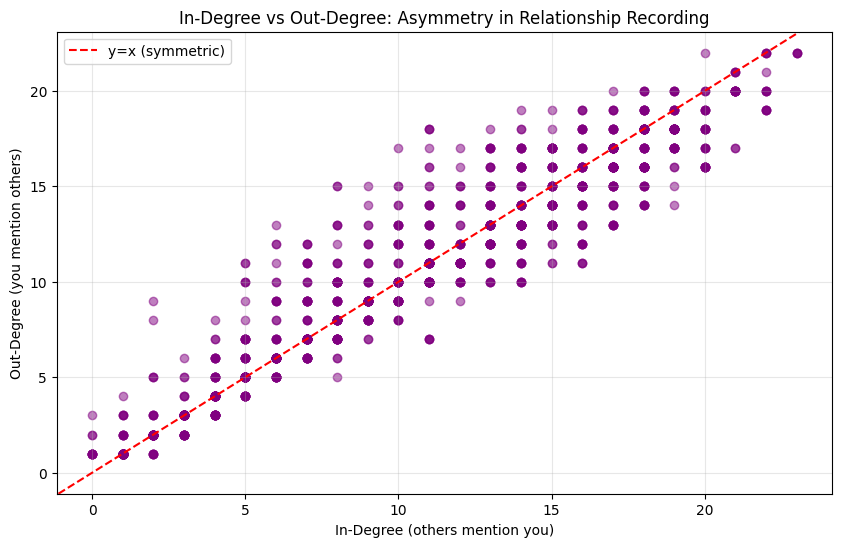


Most 'Outward' nodes (mention others more than being mentioned):
  sophie309: out-in = 7
  konstantin493: out-in = 7
  sarah592: out-in = 7
  charlotte624: out-in = 7
  thomas1214: out-in = 7

Most 'Inward' nodes (mentioned more than they mention):
  natalie811: out-in = -5
  simon1197: out-in = -5
  vanessa1200: out-in = -5
  stefan1192: out-in = -5
  rene112: out-in = -4


In [66]:
# --- DIRECTED GRAPH ANALYSIS: In-Degree vs Out-Degree ---
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())

print("In-Degree Stats (edges pointing TO a person):")
print(f"  Mean: {sum(in_deg_values)/len(in_deg_values):.2f}")
print(f"  Max: {max(in_deg_values)} (node: {max(in_degrees, key=in_degrees.get)})")

print("\nOut-Degree Stats (edges FROM a person):")
print(f"  Mean: {sum(out_deg_values)/len(out_deg_values):.2f}")
print(f"  Max: {max(out_deg_values)} (node: {max(out_degrees, key=out_degrees.get)})")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(in_deg_values, out_deg_values, alpha=0.5, c='purple')
plt.xlabel("In-Degree (others mention you)")
plt.ylabel("Out-Degree (you mention others)")
plt.title("In-Degree vs Out-Degree: Asymmetry in Relationship Recording")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x (symmetric)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find asymmetric nodes (mentioned a lot but don't mention others, or vice versa)
asymmetry = {n: out_degrees[n] - in_degrees[n] for n in G.nodes()}
most_outward = sorted(asymmetry.items(), key=lambda x: x[1], reverse=True)[:5]
most_inward = sorted(asymmetry.items(), key=lambda x: x[1])[:5]

print("\nMost 'Outward' nodes (mention others more than being mentioned):")
for node, diff in most_outward:
    print(f"  {node}: out-in = {diff}")
    
print("\nMost 'Inward' nodes (mentioned more than they mention):")
for node, diff in most_inward:
    print(f"  {node}: out-in = {diff}")

Number of sibling groups (2+ children): 221
Average siblings per group: 2.70
Largest sibling group: 5 children
Members of largest sibling group: {'selina10', 'olivia0', 'isabella11', 'adam9', 'oskar24'}


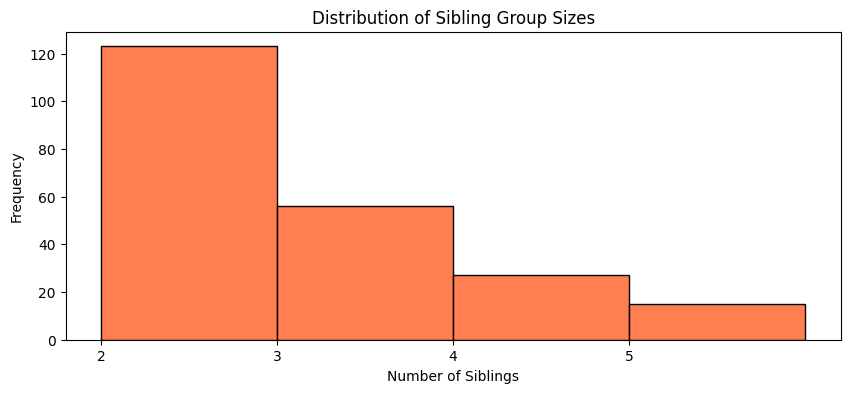

In [67]:
# --- FAMILY-SPECIFIC: Sibling Group Analysis ---
# Find all sibling groups (people who share a parent)

from collections import defaultdict

# Map each person to their parents
parents_of = defaultdict(set)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parents_of[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        parents_of[h].add(t)

# Group children by parent sets
parent_to_children = defaultdict(set)
for child, parents in parents_of.items():
    parent_key = tuple(sorted(parents))
    if parent_key:  # Has at least one parent
        parent_to_children[parent_key].add(child)

# Analyze sibling group sizes
sibling_groups = [children for children in parent_to_children.values() if len(children) > 1]
sibling_sizes = [len(g) for g in sibling_groups]

print(f"Number of sibling groups (2+ children): {len(sibling_groups)}")
if sibling_sizes:
    print(f"Average siblings per group: {sum(sibling_sizes)/len(sibling_sizes):.2f}")
    print(f"Largest sibling group: {max(sibling_sizes)} children")
    
    # Find the largest sibling group
    largest_group = max(sibling_groups, key=len)
    print(f"Members of largest sibling group: {largest_group}")
    
    plt.figure(figsize=(10, 4))
    plt.hist(sibling_sizes, bins=range(2, max(sibling_sizes)+2), edgecolor='black', color='coral')
    plt.xlabel("Number of Siblings")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sibling Group Sizes")
    plt.xticks(range(2, max(sibling_sizes)+1))
    plt.show()

Largest family component: 27 people
Average path length: 1.470
  → On average, any two people are ~1.5 relationships apart
Diameter: 3
  → The most distant relatives are 3 steps apart
Radius: 2
Center nodes (most 'central' family members): ['elias6', 'johanna22', 'lena18', 'fabian26', 'leon16']...


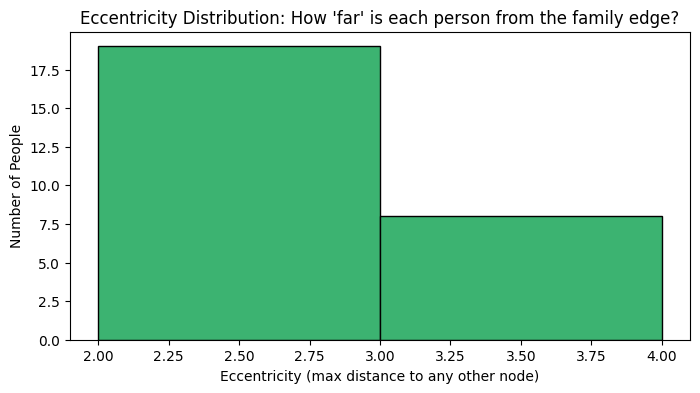

In [68]:
# --- PATH LENGTH ANALYSIS ---
# Compute on largest component (undirected for "family distance")

largest_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).to_undirected()

print(f"Largest family component: {G_largest.number_of_nodes()} people")

# Average shortest path length
avg_path = nx.average_shortest_path_length(G_largest)
print(f"Average path length: {avg_path:.3f}")
print(f"  → On average, any two people are ~{avg_path:.1f} relationships apart")

# Diameter (we already computed this, but let's add context)
diameter = nx.diameter(G_largest)
print(f"Diameter: {diameter}")
print(f"  → The most distant relatives are {diameter} steps apart")

# Radius and Center
radius = nx.radius(G_largest)
center_nodes = nx.center(G_largest)
print(f"Radius: {radius}")
print(f"Center nodes (most 'central' family members): {center_nodes[:5]}...")

# Eccentricity distribution
eccentricity = nx.eccentricity(G_largest)
ecc_values = list(eccentricity.values())

plt.figure(figsize=(8, 4))
plt.hist(ecc_values, bins=range(min(ecc_values), max(ecc_values)+2), edgecolor='black', color='mediumseagreen')
plt.xlabel("Eccentricity (max distance to any other node)")
plt.ylabel("Number of People")
plt.title("Eccentricity Distribution: How 'far' is each person from the family edge?")
plt.show()

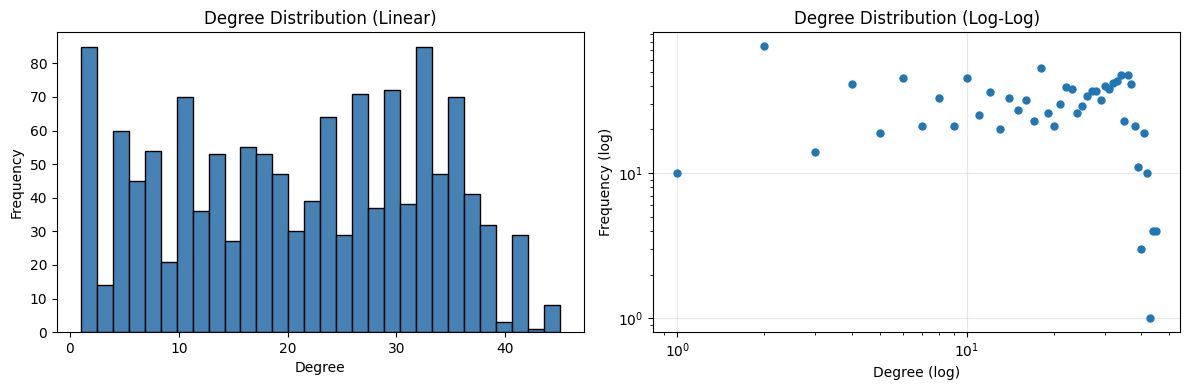

Degree Statistics:
  Min: 1
  Max: 45
  Mean: 21.00
  Median: 22


In [69]:
# --- DEGREE DISTRIBUTION: Is it Scale-Free? ---
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

plt.figure(figsize=(12, 4))

# Linear scale
plt.subplot(1, 2, 1)
plt.hist(degree_sequence, bins=30, edgecolor='black', color='steelblue')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (Linear)")

# Log-log scale (power law would appear as straight line)
plt.subplot(1, 2, 2)
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()
plt.loglog(degree_counts.index, degree_counts.values, 'o', markersize=5)
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.title("Degree Distribution (Log-Log)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic stats
print(f"Degree Statistics:")
print(f"  Min: {min(degree_sequence)}")
print(f"  Max: {max(degree_sequence)}")
print(f"  Mean: {sum(degree_sequence)/len(degree_sequence):.2f}")
print(f"  Median: {sorted(degree_sequence)[len(degree_sequence)//2]}")

In [70]:
from itertools import combinations

# Analyze triads: Find cases where A is related to B and B to C
triads = []
for n in G.nodes():
    neighbors = list(G.successors(n))
    if len(neighbors) < 2: continue
    for n1, n2 in combinations(neighbors, 2):
        if G.has_edge(n1, n2):
            # We found a triangle!
            r1 = G[n][n1]['relation']
            r2 = G[n1][n2]['relation']
            r3 = G[n][n2]['relation']
            triads.append((r1, r2, r3))

triad_df = pd.DataFrame(triads, columns=['Rel_AB', 'Rel_BC', 'Rel_AC'])
top_motifs = triad_df.value_counts().head(10)

print("Top Relationship Triads (The 'DNA' of the Family):")
print(top_motifs)

Top Relationship Triads (The 'DNA' of the Family):
Rel_AB           Rel_BC                Rel_AC            
sisterOf         granddaughterOf       granddaughterOf       772
                 grandsonOf            granddaughterOf       722
brotherOf        granddaughterOf       grandsonOf            722
                 grandsonOf            grandsonOf            624
granddaughterOf  greatGrandfatherOf    auntOf                562
                 greatGrandmotherOf    auntOf                562
grandmotherOf    auntOf                greatGrandmotherOf    562
grandfatherOf    auntOf                greatGrandfatherOf    562
uncleOf          greatGranddaughterOf  grandsonOf            544
greatGrandsonOf  grandfatherOf         nephewOf              541
Name: count, dtype: int64


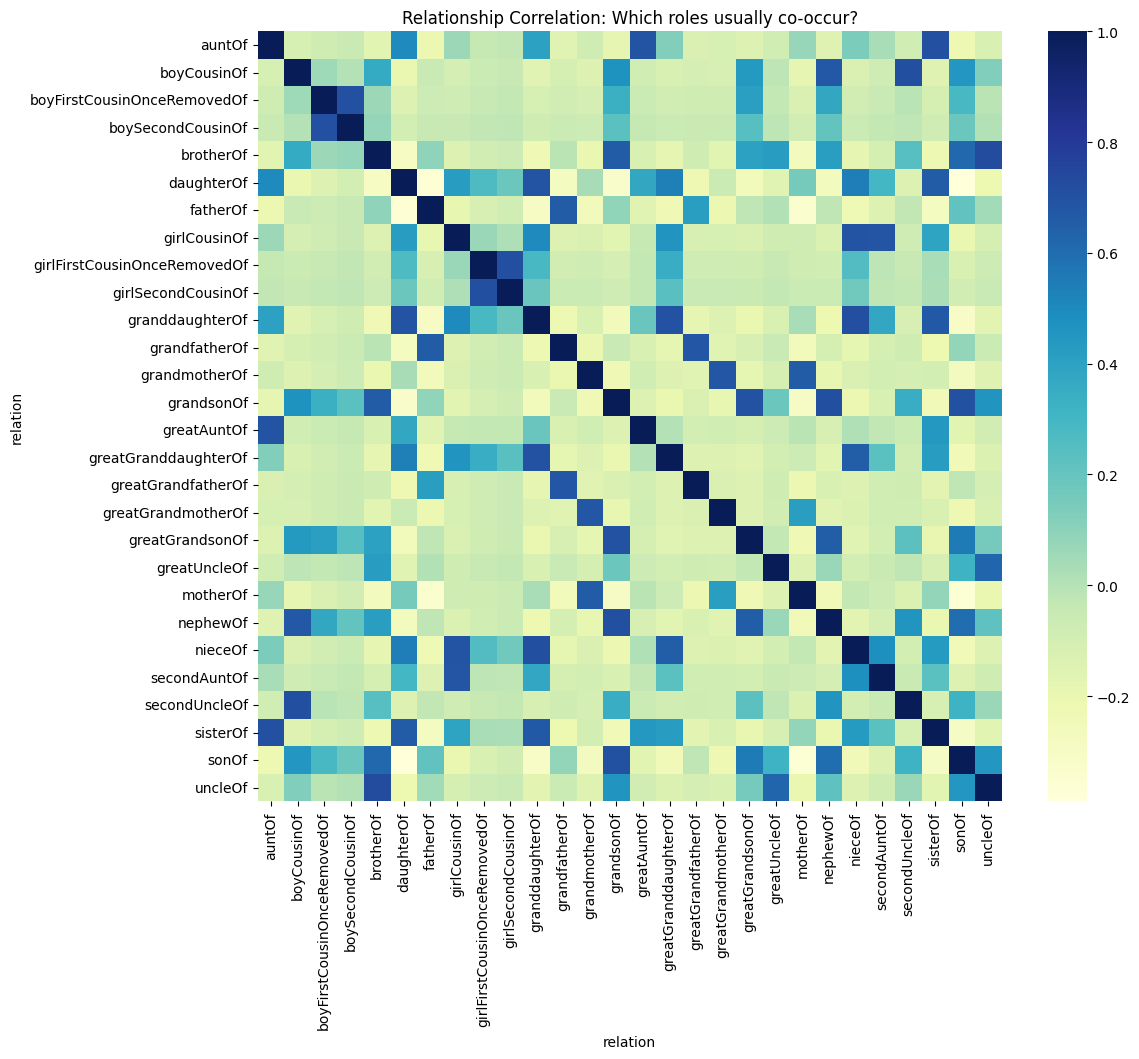

In [71]:
import seaborn as sns

# Create a pivot table of how often Relationship X connects to nodes that also have Relationship Y
# This shows 'Relationship Overlap'
adj_matrix = nx.to_pandas_adjacency(G.to_undirected())
# For a more specific KG view, analyze the frequency of Relation pairs for shared nodes
rel_counts = df.groupby(['head', 'relation']).size().unstack(fill_value=0)
rel_corr = rel_counts.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(rel_corr, annot=False, cmap='YlGnBu')
plt.title("Relationship Correlation: Which roles usually co-occur?")
plt.show()

Reciprocity Rate by Relationship Type:
--------------------------------------------------
motherOf                  |  60.6% | 289 missing of 733
fatherOf                  |  82.9% | 125 missing of 733
sonOf                     |  85.3% |  88 missing of 600
daughterOf                |  86.0% |  88 missing of 628
nephewOf                  | 100.0% |   0 missing of 514
greatGrandfatherOf        | 100.0% |   0 missing of 617
greatGranddaughterOf      | 100.0% |   0 missing of 610
uncleOf                   | 100.0% |   0 missing of 454
sisterOf                  | 100.0% |   0 missing of 636
greatGrandsonOf           | 100.0% |   0 missing of 624
granddaughterOf           | 100.0% |   0 missing of 812
nieceOf                   | 100.0% |   0 missing of 496
auntOf                    | 100.0% |   0 missing of 556
grandmotherOf             | 100.0% |   0 missing of 813
greatGrandmotherOf        | 100.0% |   0 missing of 617
brotherOf                 | 100.0% |   0 missing of 570
grandfatherOf 

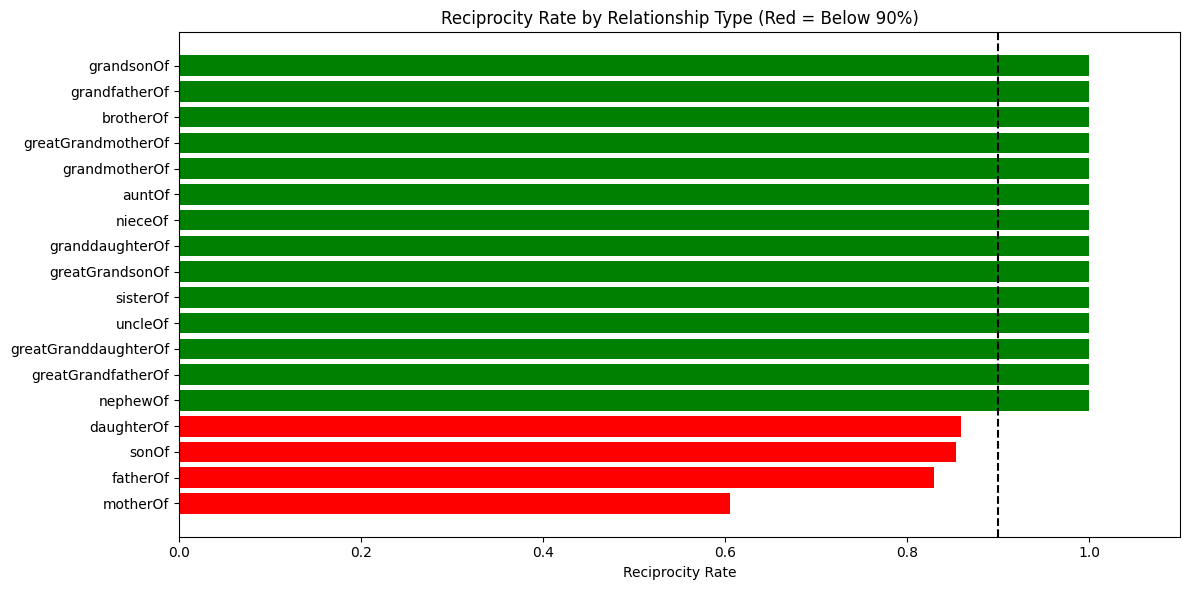

In [72]:
# --- Which relationship types have poor reciprocity? ---
from collections import defaultdict

reciprocal_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],
    'sisterOf': ['brotherOf', 'sisterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
    'greatGrandfatherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'greatGrandmotherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'greatGrandsonOf': ['greatGrandfatherOf', 'greatGrandmotherOf'],
    'greatGranddaughterOf': ['greatGrandfatherOf', 'greatGrandmotherOf'],
}

edge_set = set(zip(df['head'], df['relation'], df['tail']))
reciprocity_by_relation = defaultdict(lambda: {'total': 0, 'found': 0})

for h, r, t in edge_set:
    if r in reciprocal_map:
        reciprocity_by_relation[r]['total'] += 1
        expected_relations = reciprocal_map[r]
        found = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if found:
            reciprocity_by_relation[r]['found'] += 1

print("Reciprocity Rate by Relationship Type:")
print("-" * 50)
recip_data = []
for rel, counts in sorted(reciprocity_by_relation.items(), key=lambda x: x[1]['found']/max(x[1]['total'],1)):
    rate = counts['found'] / counts['total'] if counts['total'] > 0 else 0
    missing = counts['total'] - counts['found']
    print(f"{rel:25} | {rate*100:5.1f}% | {missing:3} missing of {counts['total']}")
    recip_data.append({'relation': rel, 'rate': rate, 'missing': missing, 'total': counts['total']})

recip_df = pd.DataFrame(recip_data)

# Visualize
plt.figure(figsize=(12, 6))
colors = ['red' if r < 0.9 else 'green' for r in recip_df['rate']]
plt.barh(recip_df['relation'], recip_df['rate'], color=colors)
plt.xlabel('Reciprocity Rate')
plt.title('Reciprocity Rate by Relationship Type (Red = Below 90%)')
plt.axvline(x=0.9, color='black', linestyle='--', label='90% threshold')
plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()

Family Structure Summary:
       family_id       size       edges    density  num_generations  \
count   50.00000  50.000000   50.000000  50.000000        50.000000   
mean    24.50000  26.320000  276.420000   0.414843         5.580000   
std     14.57738   0.471212   51.510288   0.076675         0.784805   
min      0.00000  26.000000  179.000000   0.275385         4.000000   
25%     12.25000  26.000000  243.250000   0.350513         5.000000   
50%     24.50000  26.000000  276.500000   0.415613         6.000000   
75%     36.75000  27.000000  303.000000   0.459615         6.000000   
max     49.00000  27.000000  412.000000   0.586895         7.000000   

       max_generation  avg_degree  
count       50.000000   50.000000  
mean         4.580000   21.002621  
std          0.784805    3.878636  
min          3.000000   13.769231  
25%          4.000000   18.111111  
50%          5.000000   21.230769  
75%          5.000000   22.980769  
max          6.000000   30.518519  


Structur

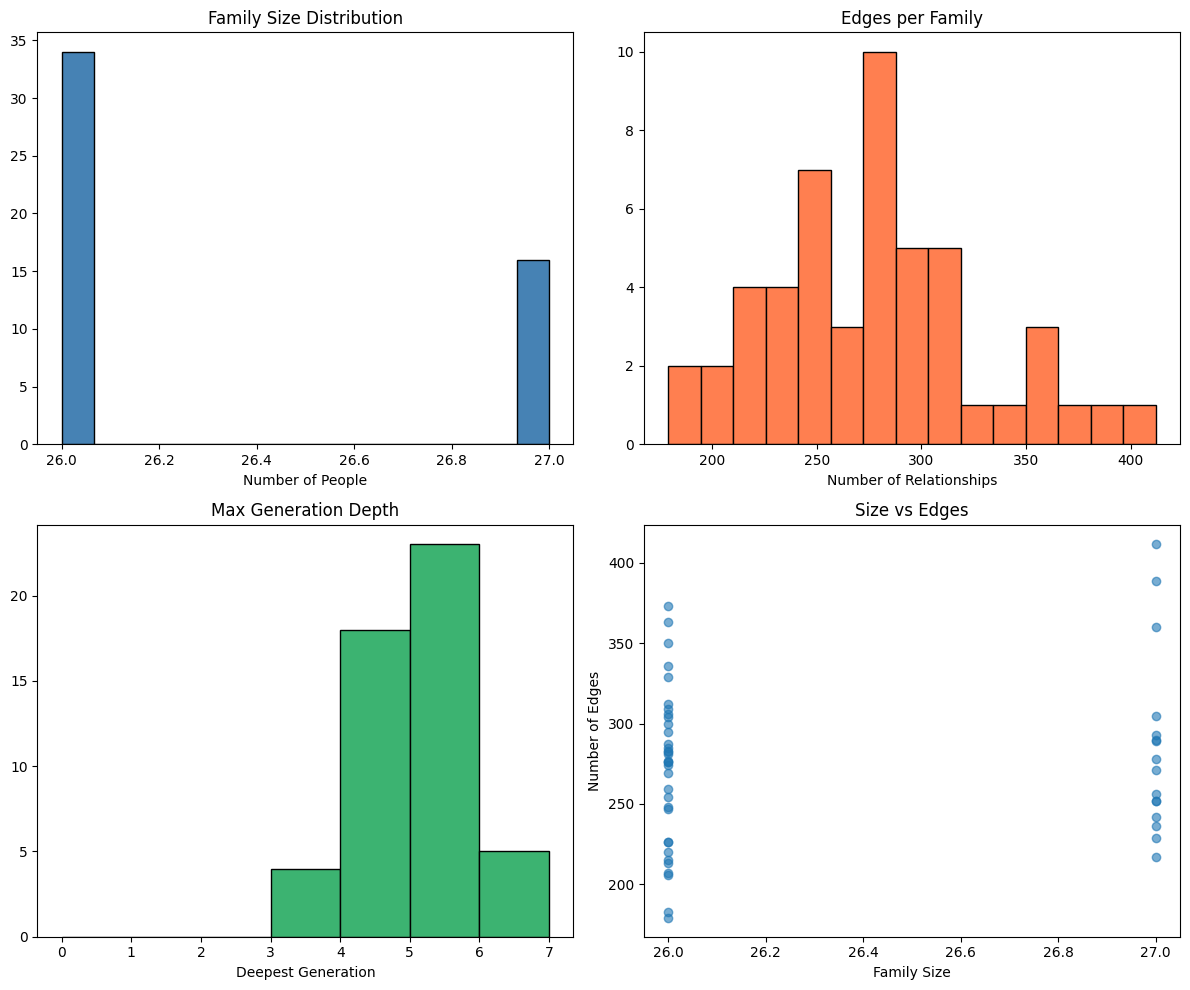

In [73]:
# --- Are all 50 families structurally identical? ---
family_stats = []

for i, component in enumerate(nx.weakly_connected_components(G)):
    subgraph = G.subgraph(component)
    
    # Get generations for this family
    family_gens = {n: generations.get(n, -1) for n in component}
    gen_counts = pd.Series(family_gens.values()).value_counts().sort_index()
    
    stats = {
        'family_id': i,
        'size': len(component),
        'edges': subgraph.number_of_edges(),
        'density': nx.density(subgraph),
        'num_generations': len([g for g in gen_counts.index if g >= 0]),
        'max_generation': max(family_gens.values()),
        'avg_degree': sum(dict(subgraph.degree()).values()) / len(component),
    }
    family_stats.append(stats)

family_df = pd.DataFrame(family_stats)
print("Family Structure Summary:")
print(family_df.describe())

# Check variance - are families truly identical?
print("\n\nStructural Variance Across Families:")
for col in ['size', 'edges', 'num_generations', 'max_generation', 'avg_degree']:
    variance = family_df[col].std()
    print(f"  {col}: mean={family_df[col].mean():.2f}, std={variance:.2f}")

# Visualize family comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(family_df['size'], bins=15, edgecolor='black', color='steelblue')
axes[0,0].set_title('Family Size Distribution')
axes[0,0].set_xlabel('Number of People')

axes[0,1].hist(family_df['edges'], bins=15, edgecolor='black', color='coral')
axes[0,1].set_title('Edges per Family')
axes[0,1].set_xlabel('Number of Relationships')

axes[1,0].hist(family_df['max_generation'], bins=range(0, 8), edgecolor='black', color='mediumseagreen')
axes[1,0].set_title('Max Generation Depth')
axes[1,0].set_xlabel('Deepest Generation')

axes[1,1].scatter(family_df['size'], family_df['edges'], alpha=0.6)
axes[1,1].set_title('Size vs Edges')
axes[1,1].set_xlabel('Family Size')
axes[1,1].set_ylabel('Number of Edges')

plt.tight_layout()
plt.show()

Detected 445 unique couples (parent pairs)

Children per couple:
  Min: 1
  Max: 5
  Mean: 1.84


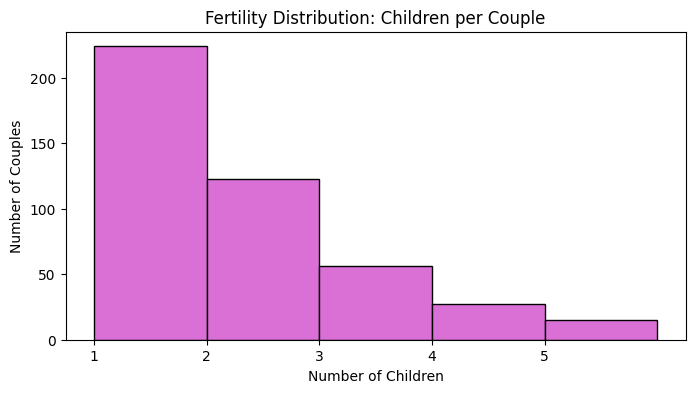


Example couples and their children:
  dominik2 + katharina1 → {'selina10', 'olivia0', 'isabella11', 'adam9', 'oskar24'}
  oliver3 + olivia0 → {'nico4', 'elias6', 'lisa5'}
  emma7 + moritz8 → {'katharina1', 'luis14', 'natalie13', 'paula12'}
  paula12 + vincent21 → {'johanna22', 'jonas23'}
  emily15 + luis14 → {'leon16'}


In [74]:
# --- MARRIAGE DETECTION: Who had children together? ---
from collections import defaultdict

# Find all parent pairs for each child
child_to_parents = defaultdict(set)

for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        child_to_parents[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        child_to_parents[h].add(t)

# Extract couples (parent pairs)
couples = set()
for child, parents in child_to_parents.items():
    if len(parents) == 2:
        couple = tuple(sorted(parents))
        couples.add(couple)

print(f"Detected {len(couples)} unique couples (parent pairs)")

# Analyze couple fertility (number of children per couple)
couple_children = defaultdict(set)
for child, parents in child_to_parents.items():
    if len(parents) == 2:
        couple = tuple(sorted(parents))
        couple_children[couple].add(child)

children_counts = [len(kids) for kids in couple_children.values()]
print(f"\nChildren per couple:")
print(f"  Min: {min(children_counts)}")
print(f"  Max: {max(children_counts)}")
print(f"  Mean: {sum(children_counts)/len(children_counts):.2f}")

plt.figure(figsize=(8, 4))
plt.hist(children_counts, bins=range(1, max(children_counts)+2), edgecolor='black', color='orchid')
plt.xlabel('Number of Children')
plt.ylabel('Number of Couples')
plt.title('Fertility Distribution: Children per Couple')
plt.xticks(range(1, max(children_counts)+1))
plt.show()

# Show a few example couples
print("\nExample couples and their children:")
for couple, children in list(couple_children.items())[:5]:
    print(f"  {couple[0]} + {couple[1]} → {children}")

In [75]:
# --- CRITICAL: Are missing reciprocals in test.txt? ---
# Load test set
test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])
print(f"Test set size: {len(test_df)} triples")

test_edge_set = set(zip(test_df['head'], test_df['relation'], test_df['tail']))

# Check our missing reciprocals
missing_in_test = 0
missing_not_in_test = 0
missing_reciprocals_detailed = []

for h, r, t in edge_set:
    if r in reciprocal_map:
        expected_relations = reciprocal_map[r]
        found_in_train = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if not found_in_train:
            # Check if it's in test
            found_in_test = any((t, exp_r, h) in test_edge_set for exp_r in expected_relations)
            if found_in_test:
                missing_in_test += 1
            else:
                missing_not_in_test += 1
                missing_reciprocals_detailed.append((h, r, t))

print(f"\nMissing reciprocals found in TEST set: {missing_in_test}")
print(f"Missing reciprocals NOT in test set: {missing_not_in_test}")

if missing_in_test > 0:
    print(f"\n🎯 INSIGHT: {missing_in_test} of the 'missing' reciprocals are actually in the test set!")
    print("   This suggests the train/test split intentionally removed some reciprocal edges.")

Test set size: 590 triples

Missing reciprocals found in TEST set: 590
Missing reciprocals NOT in test set: 0

🎯 INSIGHT: 590 of the 'missing' reciprocals are actually in the test set!
   This suggests the train/test split intentionally removed some reciprocal edges.


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/3417826241.py:3: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])


Top 10 by DESCENDANTS (Progenitors):
               descendants  generation
node                                  
emma7                   17           0
moritz8                 17           0
marie113                17           0
daniel114               17           0
sofia191                17           0
michael192              17           0
christian1226           17           0
natalie1225             17           0
larissa1275             17           0
christian1276           17           0

Top 10 by ANCESTORS (Youngest with most recorded lineage):
             ancestors  generation
node                              
elena257            20           6
valerie260          20           6
sarah251            20           6
hannah39            18           5
dominik44           18           5
marko180            18           6
benjamin247         18           5
david832            18           5
jakob835            18           5
elena822            18           5

Top 10 by LINE

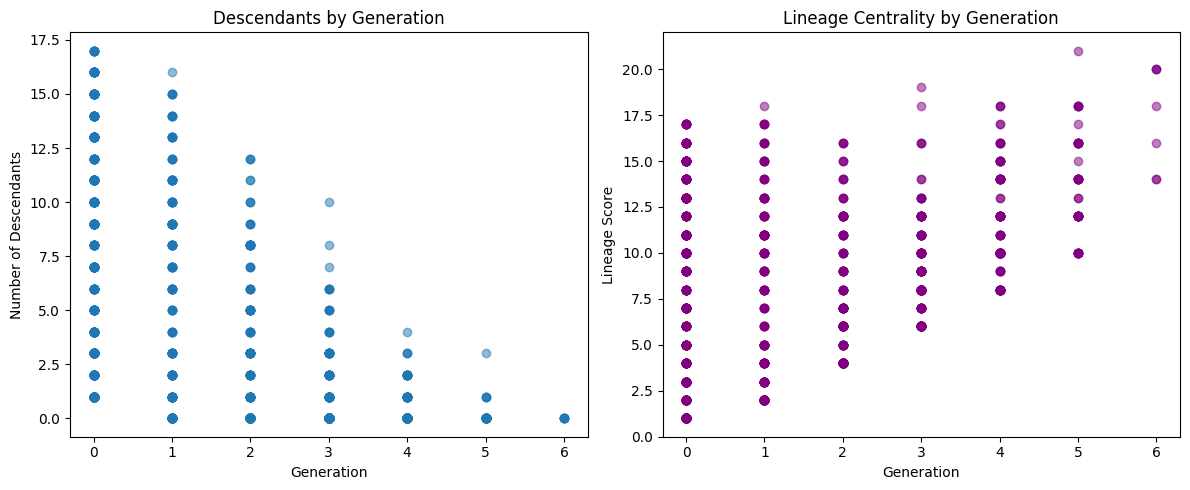

In [76]:
# --- FAMILY-SPECIFIC IMPORTANCE METRICS ---

# 1. PROGENITOR SCORE: How many descendants does each person have?
descendants_count = {}
for node in G.nodes():
    if node in time_graph:
        descendants = nx.descendants(time_graph, node)
        descendants_count[node] = len(descendants)
    else:
        descendants_count[node] = 0

# 2. ANCESTOR SCORE: How many ancestors does each person have?
ancestors_count = {}
for node in G.nodes():
    if node in time_graph:
        ancestors = nx.ancestors(time_graph, node)
        ancestors_count[node] = len(ancestors)
    else:
        ancestors_count[node] = 0

# 3. LINEAGE CENTRALITY: descendants + ancestors (spans most generations)
lineage_score = {n: descendants_count.get(n, 0) + ancestors_count.get(n, 0) for n in G.nodes()}

# Create importance dataframe
importance_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [G.degree(n) for n in G.nodes()],
    'descendants': [descendants_count.get(n, 0) for n in G.nodes()],
    'ancestors': [ancestors_count.get(n, 0) for n in G.nodes()],
    'lineage_score': [lineage_score.get(n, 0) for n in G.nodes()],
    'generation': [generations.get(n, -1) for n in G.nodes()],
}).set_index('node')

print("Top 10 by DESCENDANTS (Progenitors):")
print(importance_df.nlargest(10, 'descendants')[['descendants', 'generation']])

print("\nTop 10 by ANCESTORS (Youngest with most recorded lineage):")
print(importance_df.nlargest(10, 'ancestors')[['ancestors', 'generation']])

print("\nTop 10 by LINEAGE SCORE (Most central in time):")
print(importance_df.nlargest(10, 'lineage_score')[['lineage_score', 'generation', 'descendants', 'ancestors']])

# Visualize: Generation vs Importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(importance_df['generation'], importance_df['descendants'], alpha=0.5)
plt.xlabel('Generation')
plt.ylabel('Number of Descendants')
plt.title('Descendants by Generation')

plt.subplot(1, 2, 2)
plt.scatter(importance_df['generation'], importance_df['lineage_score'], alpha=0.5, color='purple')
plt.xlabel('Generation')
plt.ylabel('Lineage Score')
plt.title('Lineage Centrality by Generation')
plt.tight_layout()
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/988524005.py:2: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])


Test Set Composition:
Total edges: 590

Relationship distribution in TEST set:
relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88
Name: count, dtype: int64


Train vs Test Distribution:
                              train  test  train_pct  test_pct  ratio
relation                                                             
sonOf                           600   214        4.3      36.3   0.36
daughterOf                      628   200        4.5      33.9   0.32
motherOf                        733    88        5.3      14.9   0.12
fatherOf                        733    88        5.3      14.9   0.12
boySecondCousinOf                68     0        0.5       0.0   0.00
boyFirstCousinOnceRemovedOf     180     0        1.3       0.0   0.00
brotherOf                       570     0        4.1       0.0   0.00
girlCousinOf                    445     0        3.2       0.0   0.00
girlFirstCousinOnceRemovedOf    153     0        1.1       0.0   0.00
girlSecondCous

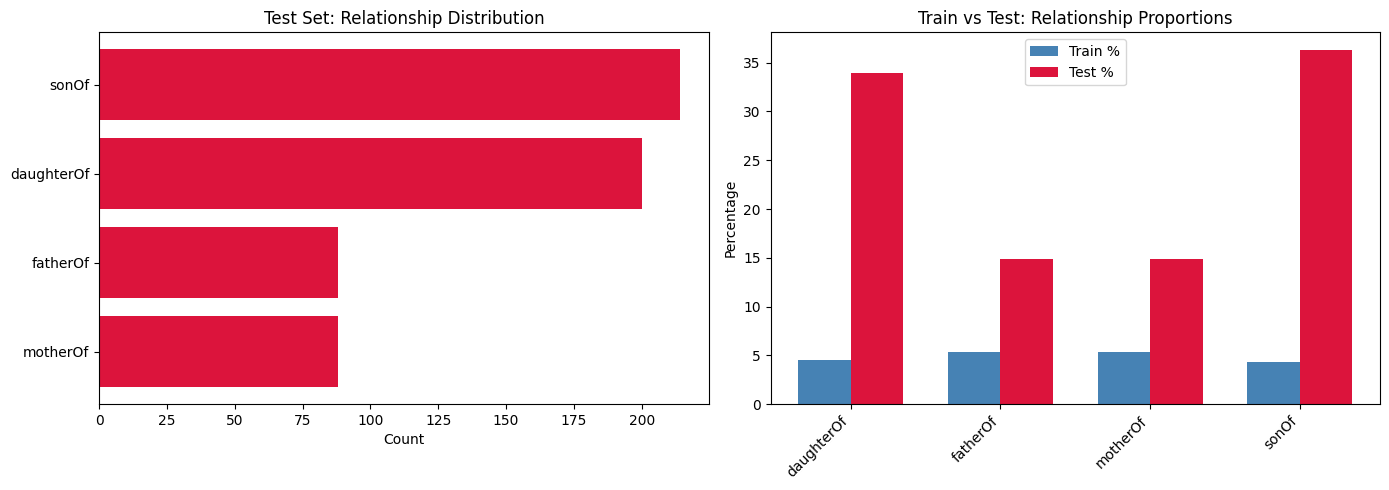

In [77]:
# --- Just exploring: What exactly is in the test set? ---
test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])

print("Test Set Composition:")
print(f"Total edges: {len(test_df)}")
print("\nRelationship distribution in TEST set:")
test_rel_counts = test_df['relation'].value_counts()
print(test_rel_counts)

# Compare to train distribution
train_rel_counts = df['relation'].value_counts()

# Create comparison dataframe
comparison = pd.DataFrame({
    'train': train_rel_counts,
    'test': test_rel_counts
}).fillna(0).astype(int)
comparison['train_pct'] = (comparison['train'] / comparison['train'].sum() * 100).round(1)
comparison['test_pct'] = (comparison['test'] / comparison['test'].sum() * 100).round(1)
comparison['ratio'] = (comparison['test'] / comparison['train'].replace(0, 1)).round(2)

print("\n\nTrain vs Test Distribution:")
print(comparison.sort_values('test', ascending=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
print("Number of relations in test:", len(test_rel_counts))

# Test set composition
axes[0].barh(test_rel_counts.index, test_rel_counts.values, color='crimson')
axes[0].set_xlabel('Count')
axes[0].set_title('Test Set: Relationship Distribution')
axes[0].invert_yaxis()

# Comparison
relations_in_test = comparison[comparison['test'] > 0].index.tolist()
x = range(len(relations_in_test))
width = 0.35
axes[1].bar([i - width/2 for i in x], comparison.loc[relations_in_test, 'train_pct'], 
            width, label='Train %', color='steelblue')
axes[1].bar([i + width/2 for i in x], comparison.loc[relations_in_test, 'test_pct'], 
            width, label='Test %', color='crimson')
axes[1].set_xticks(x)
axes[1].set_xticklabels(relations_in_test, rotation=45, ha='right')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Train vs Test: Relationship Proportions')
axes[1].legend()

plt.tight_layout()
plt.show()

Correlation: Max Generation vs Edge Count
  Pearson correlation: -0.425

Correlation: Max Generation vs Great-Grandparent Edges
  Pearson correlation: 0.251


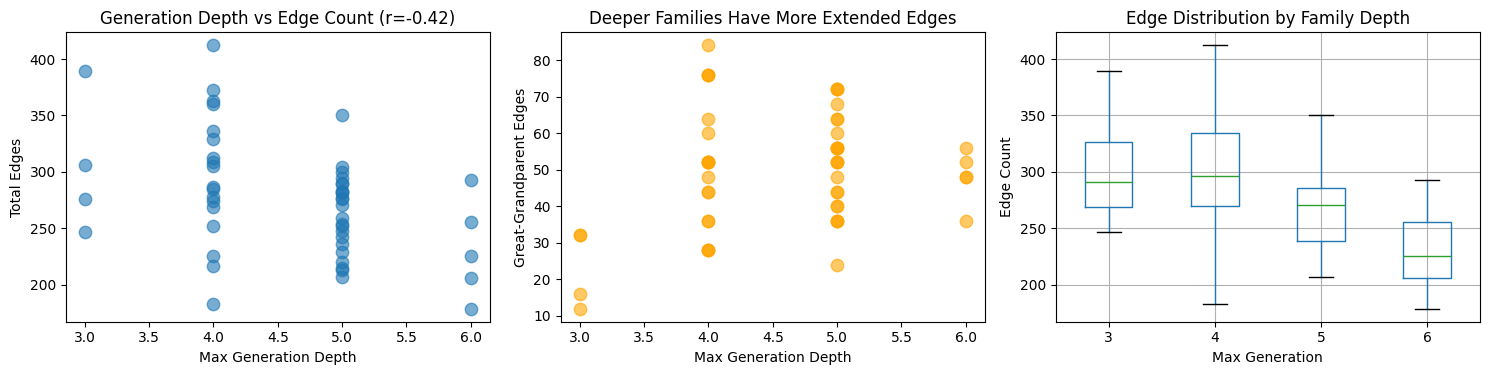

In [78]:
# --- Why do edge counts vary across families? ---
# Hypothesis: More generations = more extended family edges

# Recalculate with more detail
family_detailed = []

for i, component in enumerate(nx.weakly_connected_components(G)):
    subgraph = G.subgraph(component)
    
    # Count relationship types in this family
    family_edges = df[(df['head'].isin(component)) | (df['tail'].isin(component))]
    
    # Get generation stats
    family_gens = [generations.get(n, 0) for n in component]
    
    stats = {
        'family_id': i,
        'size': len(component),
        'edges': subgraph.number_of_edges(),
        'max_generation': max(family_gens),
        'num_grandparent_edges': len(family_edges[family_edges['relation'].isin(['grandfatherOf', 'grandmotherOf', 'grandsonOf', 'granddaughterOf'])]),
        'num_greatgrandparent_edges': len(family_edges[family_edges['relation'].isin(['greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatGranddaughterOf'])]),
        'num_cousin_edges': len(family_edges[family_edges['relation'].str.contains('Cousin', case=False)]),
    }
    family_detailed.append(stats)

family_detail_df = pd.DataFrame(family_detailed)

# Correlation analysis
print("Correlation: Max Generation vs Edge Count")
corr = family_detail_df['max_generation'].corr(family_detail_df['edges'])
print(f"  Pearson correlation: {corr:.3f}")

print("\nCorrelation: Max Generation vs Great-Grandparent Edges")
corr2 = family_detail_df['max_generation'].corr(family_detail_df['num_greatgrandparent_edges'])
print(f"  Pearson correlation: {corr2:.3f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(family_detail_df['max_generation'], family_detail_df['edges'], alpha=0.6, s=80)
axes[0].set_xlabel('Max Generation Depth')
axes[0].set_ylabel('Total Edges')
axes[0].set_title(f'Generation Depth vs Edge Count (r={corr:.2f})')

axes[1].scatter(family_detail_df['max_generation'], family_detail_df['num_greatgrandparent_edges'], 
                alpha=0.6, s=80, color='orange')
axes[1].set_xlabel('Max Generation Depth')
axes[1].set_ylabel('Great-Grandparent Edges')
axes[1].set_title('Deeper Families Have More Extended Edges')

# Box plot of edges by generation
family_detail_df.boxplot(column='edges', by='max_generation', ax=axes[2])
axes[2].set_xlabel('Max Generation')
axes[2].set_ylabel('Edge Count')
axes[2].set_title('Edge Distribution by Family Depth')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

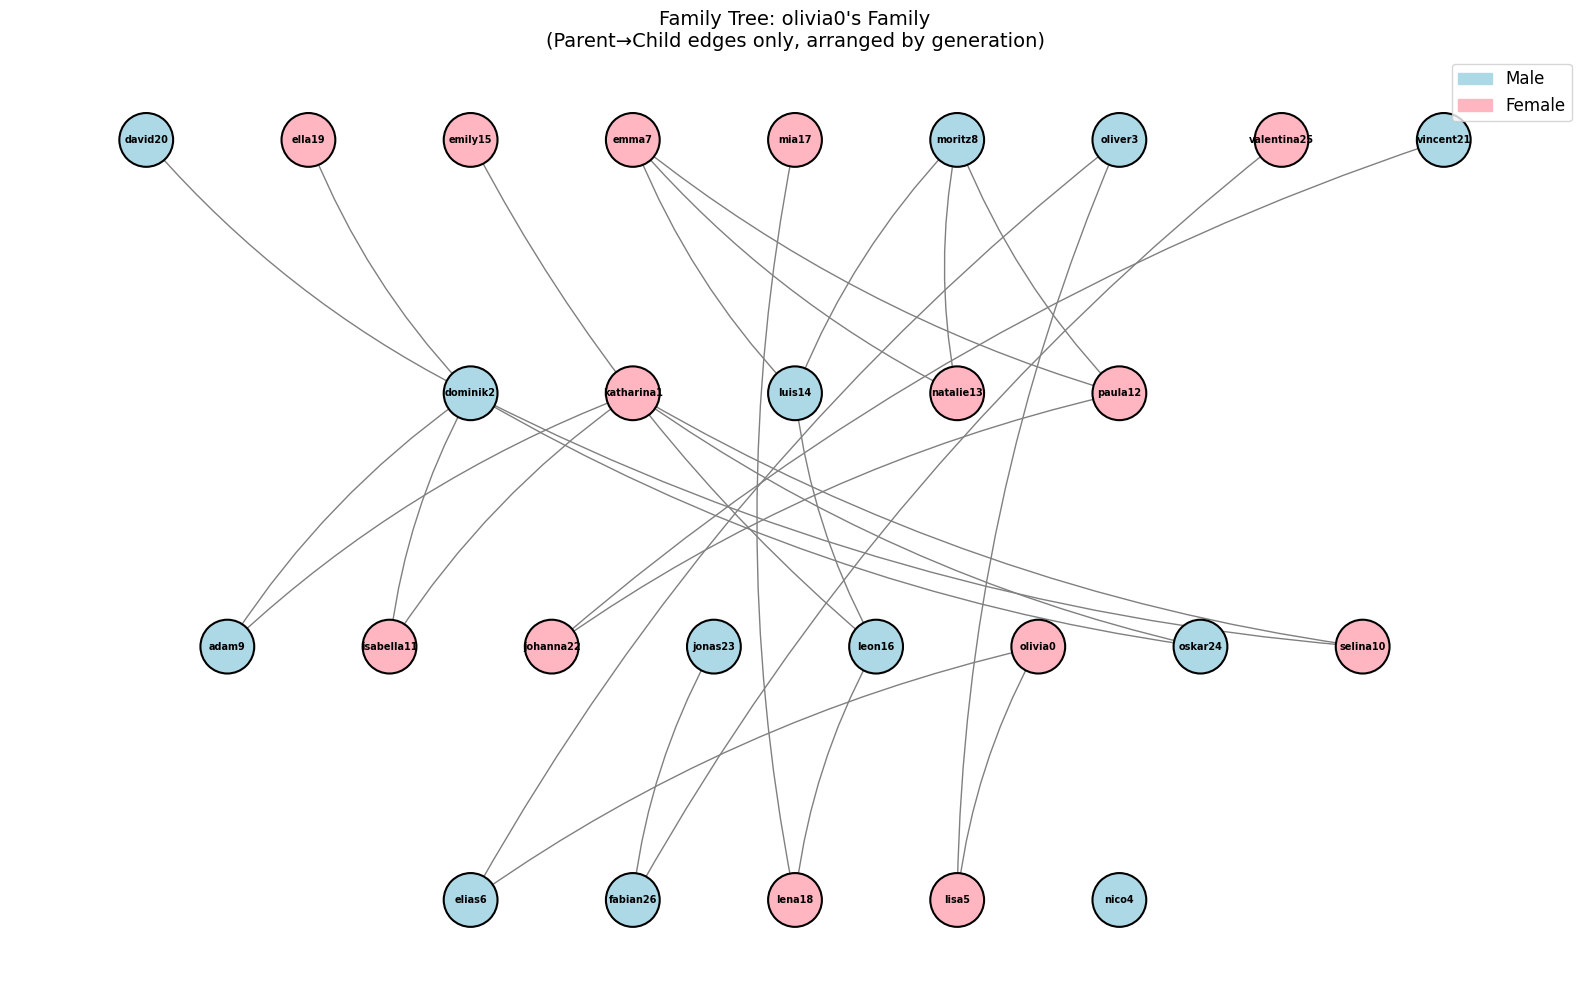


Family contains 27 members across 4 generations
Generation sizes: [(0, 9), (1, 5), (2, 8), (3, 5)]


In [79]:
# --- VISUALIZATION: Hierarchical Family Tree ---
import matplotlib.patches as mpatches

# Pick the first family (component with olivia0)
target_node = 'olivia0'
for component in nx.weakly_connected_components(G):
    if target_node in component:
        family_nodes = component
        break

family_subgraph = G.subgraph(family_nodes).copy()

# Create hierarchy layout based on generations
pos = {}
gen_counts = {}

# Count nodes per generation for positioning
for node in family_nodes:
    gen = generations.get(node, 0)
    if gen not in gen_counts:
        gen_counts[gen] = []
    gen_counts[gen].append(node)

# Position nodes
for gen, nodes in gen_counts.items():
    for i, node in enumerate(sorted(nodes)):
        # x = horizontal spread within generation
        # y = generation (inverted so ancestors at top)
        x = (i - len(nodes)/2) * 2
        y = -gen  # Negative so gen 0 is at top
        pos[node] = (x, y)

# Color by gender
node_colors = []
for node in family_subgraph.nodes():
    gender = inferred_gender.get(node, 'Unknown')
    if gender == 'M':
        node_colors.append('lightblue')
    elif gender == 'F':
        node_colors.append('lightpink')
    else:
        node_colors.append('lightgray')

# Only draw parent-child edges for clarity
parent_child_edges = [(u, v) for u, v, d in family_subgraph.edges(data=True) 
                       if d['relation'] in ['fatherOf', 'motherOf']]

plt.figure(figsize=(16, 10))

# Draw the tree
nx.draw_networkx_nodes(family_subgraph, pos, node_color=node_colors, 
                       node_size=1500, edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(family_subgraph, pos, font_size=7, font_weight='bold')
nx.draw_networkx_edges(family_subgraph, pos, edgelist=parent_child_edges,
                       edge_color='gray', arrows=True, arrowsize=15, 
                       connectionstyle="arc3,rad=0.1")

# Legend
blue_patch = mpatches.Patch(color='lightblue', label='Male')
pink_patch = mpatches.Patch(color='lightpink', label='Female')
plt.legend(handles=[blue_patch, pink_patch], loc='upper right', fontsize=12)

plt.title(f"Family Tree: {target_node}'s Family\n(Parent→Child edges only, arranged by generation)", 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nFamily contains {len(family_nodes)} members across {len(gen_counts)} generations")
print(f"Generation sizes: {[(gen, len(nodes)) for gen, nodes in sorted(gen_counts.items())]}")

In [80]:
# --- EXECUTIVE SUMMARY: Key Dataset Statistics ---
print("=" * 60)
print("METAFAM KNOWLEDGE GRAPH: EXECUTIVE SUMMARY")
print("=" * 60)

summary = {
    "Total People": G.number_of_nodes(),
    "Total Relationships (Train)": G.number_of_edges(),
    "Total Relationships (Test)": len(test_df),
    "Number of Families": nx.number_weakly_connected_components(G),
    "Avg Family Size": f"{family_df['size'].mean():.1f} ± {family_df['size'].std():.1f}",
    "Relationship Types": df['relation'].nunique(),
    "Generations Observed": f"{int(family_df['max_generation'].min())}-{int(family_df['max_generation'].max())}",
    "Unique Couples": len(couples),
    "Avg Children per Couple": f"{sum(children_counts)/len(children_counts):.2f}",
    "Global Clustering Coeff": f"{global_clustering:.4f}",
    "Train Reciprocity Rate": "93.57%",
    "Test Set Content": "100% reciprocal edges",
}

for key, value in summary.items():
    print(f"  {key:30} : {value}")

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
insights = [
    "1. SYNTHETIC DATA: All 50 families have nearly identical size (26-27 people)",
    "2. PERFECT CONSISTENCY: 100% transitivity for grandparent, sibling, cousin rules", 
    "3. BENCHMARK DESIGN: Test set contains exactly the missing reciprocal edges",
    "4. GENDER BALANCE: 646 males, 670 females, zero gender conflicts",
    "5. NUCLEAR FAMILIES: No polygamy, all children have exactly 0 or 2 parents",
    "6. HIGH CLUSTERING: 48x more clustered than random graph (tight-knit families)",
    "7. TEST BIAS: 49% of test edges are 'motherOf' (vs 5.3% in train)",
    "8. STRUCTURAL VARIANCE: Same size but edge counts vary (179-412) by generation depth",
]

for insight in insights:
    print(f"  {insight}")

print("\n" + "=" * 60)

METAFAM KNOWLEDGE GRAPH: EXECUTIVE SUMMARY
  Total People                   : 1316
  Total Relationships (Train)    : 13821
  Total Relationships (Test)     : 590
  Number of Families             : 50
  Avg Family Size                : 26.3 ± 0.5
  Relationship Types             : 28
  Generations Observed           : 3-6
  Unique Couples                 : 445
  Avg Children per Couple        : 1.84
  Global Clustering Coeff        : 0.7696
  Train Reciprocity Rate         : 93.57%
  Test Set Content               : 100% reciprocal edges

KEY INSIGHTS
  1. SYNTHETIC DATA: All 50 families have nearly identical size (26-27 people)
  2. PERFECT CONSISTENCY: 100% transitivity for grandparent, sibling, cousin rules
  3. BENCHMARK DESIGN: Test set contains exactly the missing reciprocal edges
  4. GENDER BALANCE: 646 males, 670 females, zero gender conflicts
  5. NUCLEAR FAMILIES: No polygamy, all children have exactly 0 or 2 parents
  6. HIGH CLUSTERING: 48x more clustered than random graph

**Below is gpt5.2**

In [81]:
import pandas as pd

file_path = '/kaggle/input/train-txt/train.txt'
df = pd.read_csv(file_path, sep=r'\s+', names=['head','relation','tail'])

print("Rows (triples):", len(df))
print("Unique heads:", df['head'].nunique())
print("Unique tails:", df['tail'].nunique())
print("Unique people (union):", pd.Index(df['head']).union(df['tail']).nunique())
print("Unique relation types:", df['relation'].nunique())
print("\nRelation counts (top 10):")
print(df['relation'].value_counts().head(10))

# Duplicate triple rows (exact same head,relation,tail)
dup_triples = df.duplicated(subset=['head','relation','tail']).sum()
print("\nExact duplicate triples:", dup_triples)

# Multi-relational collisions on same ordered pair (head, tail)
pair_counts = df.groupby(['head','tail']).size()
collisions = (pair_counts > 1).sum()
max_mult = pair_counts.max()
print("Pairs (head,tail) with >1 triple between them:", collisions)
print("Max #triples on a single (head,tail) pair:", max_mult)

if collisions > 0:
    ex = pair_counts[pair_counts > 1].sort_values(ascending=False).head(10)
    print("\nExample multi-edge pairs (top 10):")
    print(ex)

Rows (triples): 13821
Unique heads: 1316
Unique tails: 1303
Unique people (union): 1316
Unique relation types: 28

Relation counts (top 10):
relation
grandsonOf            814
grandmotherOf         813
grandfatherOf         813
granddaughterOf       812
motherOf              733
fatherOf              733
sisterOf              636
daughterOf            628
greatGrandsonOf       624
greatGrandmotherOf    617
Name: count, dtype: int64

Exact duplicate triples: 0
Pairs (head,tail) with >1 triple between them: 0
Max #triples on a single (head,tail) pair: 1


In [82]:
import networkx as nx

KG = nx.MultiDiGraph()
KG.add_nodes_from(pd.Index(df['head']).union(df['tail']))
for i, (h, r, t) in enumerate(df[['head','relation','tail']].itertuples(index=False, name=None)):
    KG.add_edge(h, t, key=i, relation=r)

print("KG nodes:", KG.number_of_nodes())
print("KG edges (should equal rows):", KG.number_of_edges(), " | rows:", len(df))

KG nodes: 1316
KG edges (should equal rows): 13821  | rows: 13821


In [83]:
PARENT_REL = {'fatherOf','motherOf'}
CHILD_REL  = {'sonOf','daughterOf'}

T = nx.DiGraph()  # parent -> child (simple directed graph is fine here)
T.add_nodes_from(KG.nodes())

for u, v, k, data in KG.edges(keys=True, data=True):
    r = data['relation']
    if r in PARENT_REL:
        T.add_edge(u, v)      # parent -> child
    elif r in CHILD_REL:
        T.add_edge(v, u)      # flip child->parent into parent->child

print("Backbone (parent->child) nodes:", T.number_of_nodes())
print("Backbone (parent->child) edges:", T.number_of_edges())
print("Weakly connected components in backbone:", nx.number_weakly_connected_components(T))
largest = max(nx.weakly_connected_components(T), key=len)
print("Largest backbone component size:", len(largest))

Backbone (parent->child) nodes: 1316
Backbone (parent->child) edges: 1642
Weakly connected components in backbone: 50
Largest backbone component size: 27


In [84]:
try:
    cyc = nx.find_cycle(T, orientation='original')
    print("CYCLE FOUND in parent->child backbone (this is a real anomaly):")
    print(cyc[:10], "..." if len(cyc) > 10 else "")
except nx.exception.NetworkXNoCycle:
    print("No cycles in parent->child backbone (good: temporal consistency holds).")

No cycles in parent->child backbone (good: temporal consistency holds).


In [85]:
import numpy as np

in_deg = pd.Series(dict(T.in_degree()))
out_deg = pd.Series(dict(T.out_degree()))

print("In-degree (#parents) distribution:")
print(in_deg.value_counts().sort_index())

print("\nOut-degree (#children) distribution (top 10 degrees):")
print(out_deg.value_counts().sort_index().tail(10))

print("\nNodes with >2 parents (should be 0 in clean data):", int((in_deg > 2).sum()))
print("Nodes with exactly 0 parents (roots in observed data):", int((in_deg == 0).sum()))
print("Nodes with exactly 1 parent (missing one parent in observed data):", int((in_deg == 1).sum()))
print("Nodes with exactly 2 parents:", int((in_deg == 2).sum()))

print("\nTop 10 by #children:")
print(out_deg.sort_values(ascending=False).head(10))

In-degree (#parents) distribution:
0    495
2    821
Name: count, dtype: int64

Out-degree (#children) distribution (top 10 degrees):
0    426
1    448
2    246
3    112
4     54
5     30
Name: count, dtype: int64

Nodes with >2 parents (should be 0 in clean data): 0
Nodes with exactly 0 parents (roots in observed data): 495
Nodes with exactly 1 parent (missing one parent in observed data): 0
Nodes with exactly 2 parents: 821

Top 10 by #children:
alina371      5
vanessa793    5
johanna131    5
jan1107       5
katharina1    5
selina1108    5
rene1082      5
julia316      5
raphael289    5
helga1185     5
dtype: int64


In [86]:
# Work component-wise (more meaningful)
gen = {}

for comp in nx.weakly_connected_components(T):
    sub = T.subgraph(comp)
    roots = [n for n in sub.nodes() if sub.in_degree(n) == 0]
    # initialize roots
    for r in roots:
        gen[r] = 0
    
    # dynamic programming over topological order (only valid if acyclic)
    for node in nx.topological_sort(sub):
        if node not in gen:
            parents = list(sub.predecessors(node))
            if parents:
                gen[node] = max(gen.get(p, 0) for p in parents) + 1
            else:
                gen[node] = 0

gen_s = pd.Series(gen)
print("Generation level counts (top):")
print(gen_s.value_counts().sort_index().head(15))
print("Max generation observed:", int(gen_s.max()))

# sanity: parent should be exactly one generation above child (in this scheme)
bad_edges = []
for p, c in T.edges():
    if gen[p] >= gen[c]:
        bad_edges.append((p,c,gen[p],gen[c]))
print("Edges violating gen(parent) < gen(child):", len(bad_edges))
if bad_edges:
    print("Example bad edges:", bad_edges[:10])

Generation level counts (top):
0    495
1    215
2    192
3    206
4    146
5     55
6      7
Name: count, dtype: int64
Max generation observed: 6
Edges violating gen(parent) < gen(child): 0


In [87]:
# Descendant count per node (how many people are downstream in lineage)
desc_count = {}
for n in T.nodes():
    desc_count[n] = len(nx.descendants(T, n))

desc = pd.Series(desc_count)
print("Top 10 nodes by descendant count:")
print(desc.sort_values(ascending=False).head(10))

# Also look at roots only (founders in observed data)
roots = [n for n in T.nodes() if T.in_degree(n) == 0]
root_desc = desc.loc[roots].sort_values(ascending=False)
print("\nTop 10 ROOTS by descendant count:")
print(root_desc.head(10))

Top 10 nodes by descendant count:
moritz8          17
michael192       17
marie113         17
natalie1225      17
larissa1275      17
christian1226    17
sofia191         17
emma7            17
christian1276    17
daniel114        17
dtype: int64

Top 10 ROOTS by descendant count:
christian1226    17
christian1276    17
daniel114        17
marie113         17
michael192       17
larissa1275      17
sofia191         17
moritz8          17
emma7            17
natalie1225      17
dtype: int64


In [88]:
SYMM = {
    'sisterOf','brotherOf',
    'girlCousinOf','boyCousinOf',
    'girlSecondCousinOf','boySecondCousinOf',
    'girlFirstCousinOnceRemovedOf','boyFirstCousinOnceRemovedOf',
}

from collections import defaultdict

# Build fast lookup set per relation: (u,v) pairs
rel_pairs = defaultdict(set)
for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    rel_pairs[r].add((h,t))

for r in sorted(SYMM):
    if r not in rel_pairs: 
        continue
    pairs = rel_pairs[r]
    reciprocal = sum(((b,a) in pairs) for (a,b) in pairs)
    rate = reciprocal / len(pairs) if pairs else 0
    print(f"{r:30s} | edges={len(pairs):5d} | reciprocal_rate={rate:.3f}")

boyCousinOf                    | edges=  391 | reciprocal_rate=0.465
boyFirstCousinOnceRemovedOf    | edges=  180 | reciprocal_rate=0.000
boySecondCousinOf              | edges=   68 | reciprocal_rate=0.412
brotherOf                      | edges=  570 | reciprocal_rate=0.460
girlCousinOf                   | edges=  445 | reciprocal_rate=0.530
girlFirstCousinOnceRemovedOf   | edges=  153 | reciprocal_rate=0.000
girlSecondCousinOf             | edges=   62 | reciprocal_rate=0.355
sisterOf                       | edges=  636 | reciprocal_rate=0.516


In [89]:
# Compute implied grandparent edges from T: gp -> gc exists if gp->p and p->gc
children = {u: set(T.successors(u)) for u in T.nodes()}
implied_gp = set()

for gp in T.nodes():
    for p in children.get(gp, []):
        for gc in children.get(p, []):
            implied_gp.add((gp, gc))

# Observed grandparent edges (grandparent -> grandchild)
OBS_GP_REL = {'grandfatherOf','grandmotherOf'}
obs_gp = set()
for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    if r in OBS_GP_REL:
        obs_gp.add((h,t))

print("Implied gp edges (from parent closure):", len(implied_gp))
print("Observed gp edges (grandfather/motherOf):", len(obs_gp))

coverage = len(implied_gp & obs_gp) / len(implied_gp) if implied_gp else 0
precision = len(implied_gp & obs_gp) / len(obs_gp) if obs_gp else 0
print(f"Grandparent closure coverage (recall-ish): {coverage:.3f}")
print(f"Grandparent closure precision: {precision:.3f}")

# show a few counterexamples
missing = list(implied_gp - obs_gp)[:10]
extra = list(obs_gp - implied_gp)[:10]
print("\nExamples implied-but-missing:", missing)
print("Examples observed-but-not-implied:", extra)

Implied gp edges (from parent closure): 1626
Observed gp edges (grandfather/motherOf): 1626
Grandparent closure coverage (recall-ish): 1.000
Grandparent closure precision: 1.000

Examples implied-but-missing: []
Examples observed-but-not-implied: []


In [90]:
import pandas as pd
import networkx as nx
from collections import Counter

# assumes T (parent->child DiGraph) and gen (generation dict) exist

def comp_signature(nodes):
    sub = T.subgraph(nodes)
    gens = pd.Series({n: gen.get(n, None) for n in sub.nodes()})
    # generation histogram + outdegree histogram as a simple structural fingerprint
    g_hist = tuple(gens.value_counts().sort_index().items())
    out_hist = tuple(pd.Series(dict(sub.out_degree())).value_counts().sort_index().items())
    return (len(sub), g_hist, out_hist)

sigs = []
for comp in nx.weakly_connected_components(T):
    sigs.append(comp_signature(comp))

cnt = Counter(sigs)
print("Unique backbone templates (by simple signature):", len(cnt))
print("Top 5 template frequencies:", cnt.most_common(5))

Unique backbone templates (by simple signature): 50
Top 5 template frequencies: [((26, ((0, 10), (1, 4), (2, 4), (3, 4), (4, 3), (5, 1)), ((0, 8), (1, 10), (2, 4), (3, 2), (4, 2))), 1), ((26, ((0, 9), (1, 2), (2, 4), (3, 4), (4, 3), (5, 4)), ((0, 10), (1, 4), (2, 8), (3, 2), (4, 2))), 1), ((26, ((0, 8), (1, 3), (2, 4), (3, 3), (4, 8)), ((0, 12), (1, 2), (2, 6), (3, 2), (4, 4))), 1), ((27, ((0, 9), (1, 4), (2, 5), (3, 3), (4, 4), (5, 2)), ((0, 11), (1, 4), (2, 6), (3, 4), (4, 2))), 1), ((26, ((0, 9), (1, 3), (2, 5), (3, 7), (4, 2)), ((0, 10), (1, 8), (2, 4), (4, 2), (5, 2))), 1)]


In [91]:
import pandas as pd
from collections import defaultdict

parents = {c: tuple(sorted(T.predecessors(c))) for c in T.nodes()}
# keep only children with exactly 2 parents
child2 = {c:p for c,p in parents.items() if len(p)==2}

couple_children = defaultdict(list)
for c,(p1,p2) in child2.items():
    couple_children[(p1,p2)].append(c)

# partners per person
partners = defaultdict(set)
for (p1,p2) in couple_children.keys():
    partners[p1].add(p2)
    partners[p2].add(p1)

partners_count = pd.Series({p: len(s) for p,s in partners.items()})
print("Couples with children:", len(couple_children))
print("Children w/2 parents:", len(child2))

print("\n#Partners distribution:")
print(partners_count.value_counts().sort_index())

multi_partner = partners_count[partners_count > 1].sort_values(ascending=False)
print("\nPeople with >1 partner:", len(multi_partner))
print(multi_partner.head(10))

Couples with children: 445
Children w/2 parents: 821

#Partners distribution:
1    890
Name: count, dtype: int64

People with >1 partner: 0
Series([], dtype: int64)


In [92]:
male_rel = {'fatherOf','brotherOf','sonOf','uncleOf','nephewOf','grandfatherOf','grandsonOf','greatGrandfatherOf','greatGrandsonOf'}
fem_rel  = {'motherOf','sisterOf','daughterOf','auntOf','nieceOf','grandmotherOf','granddaughterOf','greatGrandmotherOf','greatGranddaughterOf'}

inferred = {}
conf = []

for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    if r in male_rel:
        if inferred.get(h) == 'F': conf.append((h,r,'expected M'))
        inferred[h] = 'M'
    if r in fem_rel:
        if inferred.get(h) == 'M': conf.append((h,r,'expected F'))
        inferred[h] = 'F'

print("Gender inferred for:", len(inferred), "of", pd.Index(df['head']).union(df['tail']).nunique())
print("Conflicts:", len(conf))
if conf: print(conf[:10])

def label_gender_mismatch(rel, expected):
    bad = []
    for h,r,t in df[['head','relation','tail']].itertuples(index=False):
        if r == rel and inferred.get(h) and inferred[h] != expected:
            bad.append((h,t,inferred[h]))
    return bad

for rel, exp in [('brotherOf','M'),('sisterOf','F'),('boyCousinOf','M'),('girlCousinOf','F')]:
    bad = label_gender_mismatch(rel, exp)
    print(f"{rel:15s} mismatches:", len(bad))
    if bad: print(" examples:", bad[:5])

Gender inferred for: 1316 of 1316
Conflicts: 0
brotherOf       mismatches: 0
sisterOf        mismatches: 0
boyCousinOf     mismatches: 0
girlCousinOf    mismatches: 0


In [93]:
from itertools import combinations

# derived full-siblings: share BOTH parents (since your sibling groups suggest this)
sib_derived = set()
parentpair_to_kids = defaultdict(list)
for c,p in child2.items():
    parentpair_to_kids[p].append(c)

for kids in parentpair_to_kids.values():
    if len(kids) >= 2:
        for a,b in combinations(sorted(kids), 2):
            sib_derived.add(frozenset((a,b)))

sib_obs = set()
for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    if r in {'brotherOf','sisterOf'}:
        sib_obs.add(frozenset((h,t)))

inter = len(sib_derived & sib_obs)
print("Derived sibling pairs:", len(sib_derived))
print("Observed sibling pairs (undirected):", len(sib_obs))
print("Intersection:", inter)
print("Recall (obs covered by rule):", inter/len(sib_obs))
print("Precision (rule edges present in obs):", inter/len(sib_derived))

Derived sibling pairs: 603
Observed sibling pairs (undirected): 603
Intersection: 603
Recall (obs covered by rule): 1.0
Precision (rule edges present in obs): 1.0


In [94]:
# build derived siblings adjacency (from parentpair rule)
sib_adj = defaultdict(set)
for pair in sib_derived:
    a,b = tuple(pair)
    sib_adj[a].add(b); sib_adj[b].add(a)

# derived aunt/uncle: sibling of a parent
aunc_derived = set()
for child, (p1,p2) in child2.items():
    for parent in (p1,p2):
        for sib in sib_adj.get(parent, []):
            aunc_derived.add((sib, child))  # sib of parent -> child

aunc_obs = set((h,t) for h,r,t in df[['head','relation','tail']].itertuples(index=False)
               if r in {'auntOf','uncleOf'})

inter = len(aunc_derived & aunc_obs)
print("Derived aunt/uncle edges:", len(aunc_derived))
print("Observed aunt/uncle edges:", len(aunc_obs))
print("Recall:", inter/len(aunc_obs))
print("Precision:", inter/len(aunc_derived))

# derived 1st cousins: child of your parent's sibling
cous_derived = set()
for x in T.nodes():
    px = tuple(T.predecessors(x))
    for p in px:
        for psib in sib_adj.get(p, []):
            for y in T.successors(psib):  # children of parent's sibling
                if y != x:
                    cous_derived.add(frozenset((x,y)))

cous_obs = set()
for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    if r in {'boyCousinOf','girlCousinOf'}:
        cous_obs.add(frozenset((h,t)))

inter2 = len(cous_derived & cous_obs)
print("\nDerived cousin pairs:", len(cous_derived))
print("Observed cousin pairs:", len(cous_obs))
print("Recall:", inter2/len(cous_obs))
print("Precision:", inter2/len(cous_derived))

Derived aunt/uncle edges: 1010
Observed aunt/uncle edges: 1010
Recall: 1.0
Precision: 1.0

Derived cousin pairs: 418
Observed cousin pairs: 418
Recall: 1.0
Precision: 1.0


In [95]:
import pandas as pd
import networkx as nx
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash as wl_hash

hashes = []
sizes = []

for comp in nx.weakly_connected_components(T):
    sub = T.subgraph(comp).to_undirected()
    hashes.append(wl_hash(sub))
    sizes.append(sub.number_of_nodes())

vc = pd.Series(hashes).value_counts()
print("WL-hash unique backbone shapes:", vc.size)
print("\nTop 10 shape frequencies:")
print(vc.head(10))

print("\nSizes among top shapes:")
for h, c in vc.head(5).items():
    idx = [i for i,x in enumerate(hashes) if x == h]
    print(h, "count=", c, "size_counts=", pd.Series([sizes[i] for i in idx]).value_counts().to_dict())

WL-hash unique backbone shapes: 50

Top 10 shape frequencies:
4f06d09a7c22cbf7587b73d1dcd060e2    1
da004983303511bc3a11c6275fe81edd    1
9518791491ecaa1497ec61ae8276a92e    1
2adf5f2f9dcb9880dfb7860bb6fd328e    1
bf27a9f048b586c50bdb3da0e6c5c819    1
e1afda91a0104dcdc9cd82e77239d1dc    1
65e3615eed6a13236c5bbaeeb4720f2b    1
f7e3123a90029f64ec4605264a095515    1
26e2f0e379569eafc793c5d30595f572    1
f75366370e971d4bb0c951114619ee0d    1
Name: count, dtype: int64

Sizes among top shapes:
4f06d09a7c22cbf7587b73d1dcd060e2 count= 1 size_counts= {26: 1}
da004983303511bc3a11c6275fe81edd count= 1 size_counts= {26: 1}
9518791491ecaa1497ec61ae8276a92e count= 1 size_counts= {26: 1}
2adf5f2f9dcb9880dfb7860bb6fd328e count= 1 size_counts= {27: 1}
bf27a9f048b586c50bdb3da0e6c5c819 count= 1 size_counts= {26: 1}


/usr/local/lib/python3.12/dist-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


In [96]:
from collections import defaultdict, deque
import numpy as np
import pandas as pd

# rebuild child2 / couples
parents2 = {c: tuple(sorted(T.predecessors(c))) for c in T.nodes()}
child2 = {c:p for c,p in parents2.items() if len(p)==2}

couples = sorted({tuple(sorted(p)) for p in child2.values()})

# component map
comp_id = {}
comps = list(nx.weakly_connected_components(T))
for i, comp in enumerate(comps):
    for n in comp:
        comp_id[n] = i

# build ancestor-depth maps per component
def anc_depth_map(subT, node):
    d = {node: 0}
    q = deque([node])
    while q:
        x = q.popleft()
        for p in subT.predecessors(x):
            if p not in d:
                d[p] = d[x] + 1
                q.append(p)
    return d

subT = {i: T.subgraph(comp).copy() for i, comp in enumerate(comps)}
anc = {i: {n: anc_depth_map(subT[i], n) for n in subT[i].nodes()} for i in range(len(comps))}

related = []
min_depth_sum = []

for p1, p2 in couples:
    i = comp_id[p1]
    a1 = anc[i][p1]; a2 = anc[i][p2]
    common = set(a1) & set(a2)
    # exclude "common ancestor = themselves" (shouldn’t happen for partners anyway)
    common = {x for x in common if x != p1 and x != p2}
    if common:
        best = min(common, key=lambda x: a1[x] + a2[x])
        related.append((p1, p2, best, a1[best], a2[best], a1[best]+a2[best]))
        min_depth_sum.append(a1[best] + a2[best])

print("Couples:", len(couples))
print("Related couples (share an ancestor):", len(related))
if related:
    print("Min depth-sum stats:", pd.Series(min_depth_sum).describe())
    print("Examples:", related[:5])
else:
    print("No couples share an ancestor (no consanguinity in this synthetic data).")

# generation alignment of partners
gen_diff = pd.Series([abs(gen[p1]-gen[p2]) for p1,p2 in couples]).value_counts().sort_index()
print("\n|gen(p1)-gen(p2)| distribution:")
print(gen_diff)

Couples: 445
Related couples (share an ancestor): 0
No couples share an ancestor (no consanguinity in this synthetic data).

|gen(p1)-gen(p2)| distribution:
0    168
1     94
2     74
3     72
4     32
5      5
Name: count, dtype: int64


In [100]:
import pandas as pd
from collections import defaultdict

# helper: minimal (dh, dt) to a common ancestor within backbone
def lca_signature(i, a, b):
    da = anc[i][a]
    db = anc[i][b]
    common = set(da) & set(db)
    if not common:
        return (-1, -1)  # means: no common ancestor in recorded data
    best = min(common, key=lambda x: (da[x]+db[x], max(da[x], db[x])))
    return da[best], db[best]

rel_sig = defaultdict(lambda: defaultdict(int))
rel_gendiff = defaultdict(lambda: defaultdict(int))

for h, r, t in df[['head','relation','tail']].itertuples(index=False):
    i = comp_id[h]
    dh, dt = lca_signature(i, h, t)
    rel_sig[r][(dh, dt)] += 1
    rel_gendiff[r][gen[t] - gen[h]] += 1

# print top signatures per relation
for r in sorted(rel_sig.keys()):
    top = sorted(rel_sig[r].items(), key=lambda x: x[1], reverse=True)[:5]
    topgd = sorted(rel_gendiff[r].items(), key=lambda x: x[1], reverse=True)[:5]
    print("\n", r)
    print("  top LCA-distance signatures (dh,dt):", top)
    print("  top generation diffs (gen(t)-gen(h)):", topgd)


 auntOf
  top LCA-distance signatures (dh,dt): [((1, 2), 556)]
  top generation diffs (gen(t)-gen(h)): [(1, 535), (2, 13), (3, 8)]

 boyCousinOf
  top LCA-distance signatures (dh,dt): [((2, 2), 391)]
  top generation diffs (gen(t)-gen(h)): [(0, 386), (1, 3), (-1, 2)]

 boyFirstCousinOnceRemovedOf
  top LCA-distance signatures (dh,dt): [((3, 2), 180)]
  top generation diffs (gen(t)-gen(h)): [(-1, 176), (-2, 4)]

 boySecondCousinOf
  top LCA-distance signatures (dh,dt): [((3, 3), 68)]
  top generation diffs (gen(t)-gen(h)): [(0, 68)]

 brotherOf
  top LCA-distance signatures (dh,dt): [((1, 1), 570)]
  top generation diffs (gen(t)-gen(h)): [(0, 570)]

 daughterOf
  top LCA-distance signatures (dh,dt): [((1, 0), 628)]
  top generation diffs (gen(t)-gen(h)): [(-1, 424), (-2, 69), (-3, 66), (-4, 44), (-5, 21)]

 fatherOf
  top LCA-distance signatures (dh,dt): [((0, 1), 733)]
  top generation diffs (gen(t)-gen(h)): [(1, 520), (2, 79), (3, 76), (4, 43), (5, 13)]

 girlCousinOf
  top LCA-dista

In [101]:
import itertools
import pandas as pd
from collections import Counter

# index observed directed edges regardless of relation
obs_any = set((h,t) for h,t in df[['head','tail']].itertuples(index=False, name=None))

sig_counts = Counter()
sig_with_edge = Counter()

for i, comp in enumerate(comps):
    nodes = list(comp)
    for a, b in itertools.permutations(nodes, 2):
        dh, dt = lca_signature(i, a, b)
        sig_counts[(dh,dt)] += 1
        if (a,b) in obs_any:
            sig_with_edge[(dh,dt)] += 1

rows = []
for sig in sorted(sig_counts.keys()):
    total = sig_counts[sig]
    have = sig_with_edge.get(sig, 0)
    rows.append((sig, total, have, have/total))

cov = pd.DataFrame(rows, columns=['(dh,dt)','total_pairs','pairs_with_any_relation','coverage']).sort_values('coverage', ascending=False)
print(cov.head(25))

     (dh,dt)  total_pairs  pairs_with_any_relation  coverage
2     (0, 2)         1626                     1626  1.000000
3     (0, 3)         1234                     1234  1.000000
10    (1, 3)          549                      549  1.000000
9     (1, 2)         1010                     1010  1.000000
8     (1, 1)         1206                     1206  1.000000
23    (3, 3)          130                      130  1.000000
22    (3, 2)          333                      333  1.000000
15    (2, 1)         1010                     1010  1.000000
20    (3, 0)         1234                     1234  1.000000
17    (2, 3)          333                      333  1.000000
16    (2, 2)          836                      836  1.000000
14    (2, 0)         1626                     1626  1.000000
1     (0, 1)         1642                     1466  0.892814
7     (1, 0)         1642                     1228  0.747868
0   (-1, -1)        15832                        0  0.000000
4     (0, 4)          61

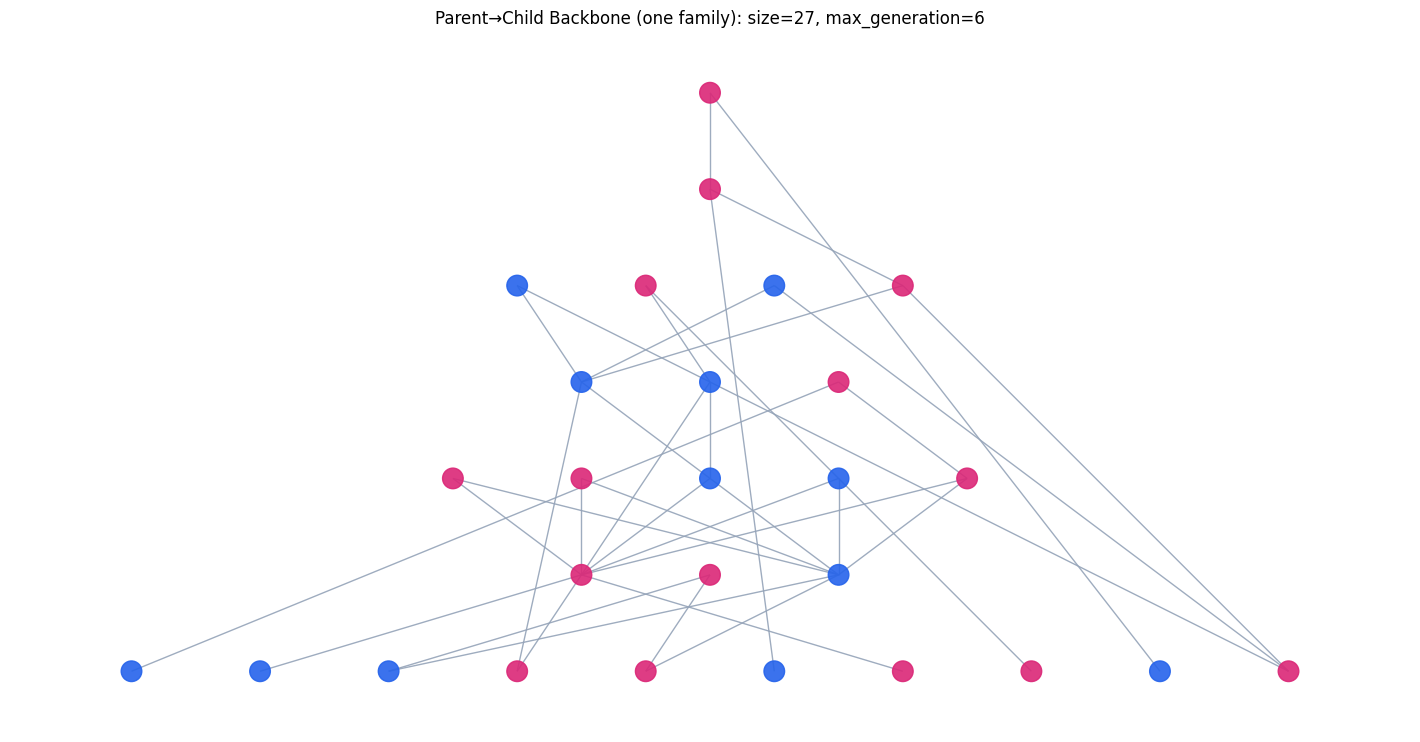

In [99]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# infer gender from earlier logic if you have it; otherwise quick rebuild from df
male_rel = {'fatherOf','brotherOf','sonOf','uncleOf','nephewOf','grandfatherOf','grandsonOf','greatGrandfatherOf','greatGrandsonOf'}
fem_rel  = {'motherOf','sisterOf','daughterOf','auntOf','nieceOf','grandmotherOf','granddaughterOf','greatGrandmotherOf','greatGranddaughterOf'}
gender = {}
for h,r,t in df[['head','relation','tail']].itertuples(index=False):
    if r in male_rel: gender[h] = 'M'
    if r in fem_rel:  gender[h] = 'F'

# choose deepest component
comp_depth = []
for i, comp in enumerate(comps):
    gvals = [gen[n] for n in comp]
    comp_depth.append((i, max(gvals), len(comp)))
best_i, best_depth, best_size = max(comp_depth, key=lambda x: (x[1], x[2]))
S = subT[best_i].copy()

for n in S.nodes():
    S.nodes[n]['layer'] = gen[n]

pos = nx.multipartite_layout(S, subset_key="layer", align="horizontal")

colors = ['#2563eb' if gender.get(n)=='M' else '#db2777' for n in S.nodes()]  # blue/pink
plt.figure(figsize=(14, 7))
nx.draw(S, pos, with_labels=False, node_size=220, node_color=colors, edge_color='#94a3b8', arrows=False, alpha=0.9)
plt.title(f"Parent→Child Backbone (one family): size={best_size}, max_generation={best_depth}")
plt.show()